This notebook provides an analysis of the relationship between:
- the amount of allocated cubes and the robot type (A or B) 
- the amount of allocated cubes and NVC feature (NVC-robot or non-NVC robot)

Steps:
- descriptive statistics (to understand data better, to find patterns)
- correlation analysis.
- dependent t-test, because you would not expect that allocation of cubes to one robot is not related to the allocation of cubes to the other robot. Here we assume normality and conduct normality test
- If the data is skewed we conduct Wilcoxon paired test, because the data is dependent


In [0]:
# Global constants
invalid_participant = [1,4,18]  # Participants whose data is invalid data
head_switch_participant = 27 # The last participant where the left robot had red face expressions
BEFORE_SWITCH = True
DATA_PATH='/content/PHRIExpData/'

**Imports/Google Auth/G-Drive mounting**
---

In [0]:
import pandas as pd
import scipy.stats as stat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as et
import os
import re
from pathlib import Path
from scipy import stats
import pylab as pl


plt.style.use(['fast'])
plt.style.use(['seaborn-poster'])

In [0]:
# Upload files from shared GDrive folder to Google Colab Workbook

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.preprocessing import StandardScaler

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Reading Questionnaire file
json_import = drive.CreateFile({'id':'1KHB1moJSzc-iCWqWI0uh3BPAwVIG7QW9'})
json_import.GetContentFile('results-survey128918.csv')
df = pd.read_csv('results-survey128918.csv')

In [0]:
LOCAL_FOLDER_NAME = 'PHRIExpData'
if LOCAL_FOLDER_NAME not in os.listdir():
  os.mkdir(LOCAL_FOLDER_NAME)
if len(os.listdir(LOCAL_FOLDER_NAME)) <=0:
  file_list = drive.ListFile({'q': "'1LS1ueCxeR7UWjfbsJzm3yHmFpkoyvuRY' in parents"}).GetList()

  for f in file_list:
    if f['title'].startswith('participant_'):
      print('title: %s, id: %s' % (f['title'], f['id']))
      fname = os.path.join(LOCAL_FOLDER_NAME, f['title'])
      f_ = drive.CreateFile({'id': f['id']})
      f_.GetContentFile(fname)

title: participant_7.csv, id: 1CMeV4UqFoYE0MgDUFySaks96LN3H2kPc
title: participant_42.csv, id: 1ndknNvd22XvtozQ4AVLoeLEkgNUurxdy
title: participant_15.csv, id: 1UlUvEtvaDsJX3g8tooq6I-QWPTnYwJp2
title: participant_23.csv, id: 14wleNhqYvBMi_iTANsxVjmdz1KCGG8cU
title: participant_49.csv, id: 1H_8JMtyzxFQysWaGfUR3WhrTXqGB4JSi
title: participant_44.csv, id: 1kRU1AQTOBDrgtzW_TxWtoD-a8e6ma30o
title: participant_22.csv, id: 1zk5z9FqK8fTMykqP_1GD97RmlwYVMpMM
title: participant_10.csv, id: 1qaGuuyTnfBFDN4kahHcXvlu837djRoBc
title: participant_25.csv, id: 1O4O6q4ho_pScTbOoDgp7kcZEjnY5ksII
title: participant_2.csv, id: 1jMj4KvVbFBtwm0HyLcYXe5rrYjGN8HnV
title: participant_52.csv, id: 1bkjd2v78KWvLGjlSPb_xS-cGq4CoMZ7U
title: participant_53.csv, id: 1KmpnI0dhbYFTgjABLdi-pzwq79zZr_pQ
title: participant_37.csv, id: 1sqdk7mkaoweNFs8PByrSLuJlBE2JpA_P
title: participant_51.csv, id: 1zFSmImT2iAH9jN6QTxSMTc1ryMZMV3-6
title: participant_29.csv, id: 1e1AkYlRm93LI0N2LuIYtmRJwwynoRe7a
title: participant_43.csv, 

**Reading Cube Allocation CSV**
---

In [0]:
# Iterate over files and find csv files that have allocation of cubes for each participant
dfs = []

for path in Path(DATA_PATH).rglob('participant_*.csv'): 
      participant_id = int(re.search(r'\d+', path.name).group())
      if participant_id in invalid_participant:
          continue
      temp = pd.read_csv(path)
      temp["scene"] = temp["scene"].str[-1:]
      temp["scene"] = temp["scene"].astype('int')
      temp["participant"] = participant_id
      temp["NVC_A"] = False
      temp["NVC_B"] = False
      
      if int(participant_id) % 2 == 0:
          nvc = "A"
          temp["NVC_A"] = True
      else:
          nvc = "B"
          temp["NVC_B"] = True

      temp["NVC"] = nvc
      temp["allocation_metric"] = (temp["robot_b"] - temp["robot_a"]) / (temp["robot_a"] + temp["robot_b"])

      
      if participant_id < head_switch_participant: 
        temp["head_group"] = 0 
      else:
        temp["head_group"] = 1
        
      dfs.append(temp)


raw_data = pd.concat(dfs, axis=0, ignore_index=True)
raw_data["allocation_metric"].fillna(0.0, inplace=True) # handle 0/0
raw_data.head()

,scene,robot_a,robot_b,participant,NVC_A,NVC_B,NVC,allocation_metric,head_group
0,0,1,1,53,False,True,B,0.000000,1
1,1,0,1,53,False,True,B,1.000000,1
2,2,1,1,53,False,True,B,0.000000,1
3,3,0,7,53,False,True,B,1.000000,1
4,4,3,4,53,False,True,B,0.142857,1


In [0]:
"" # Find the total amount of cubes that participants allocated
cubes_per_participant = raw_data.groupby("participant").sum()
cubes_per_participant = cubes_per_participant.drop(columns=['scene'])
cubes_per_participant['total_cubes'] = cubes_per_participant['robot_a'] + cubes_per_participant['robot_b'] 

## **Descriptive statistics: plots**




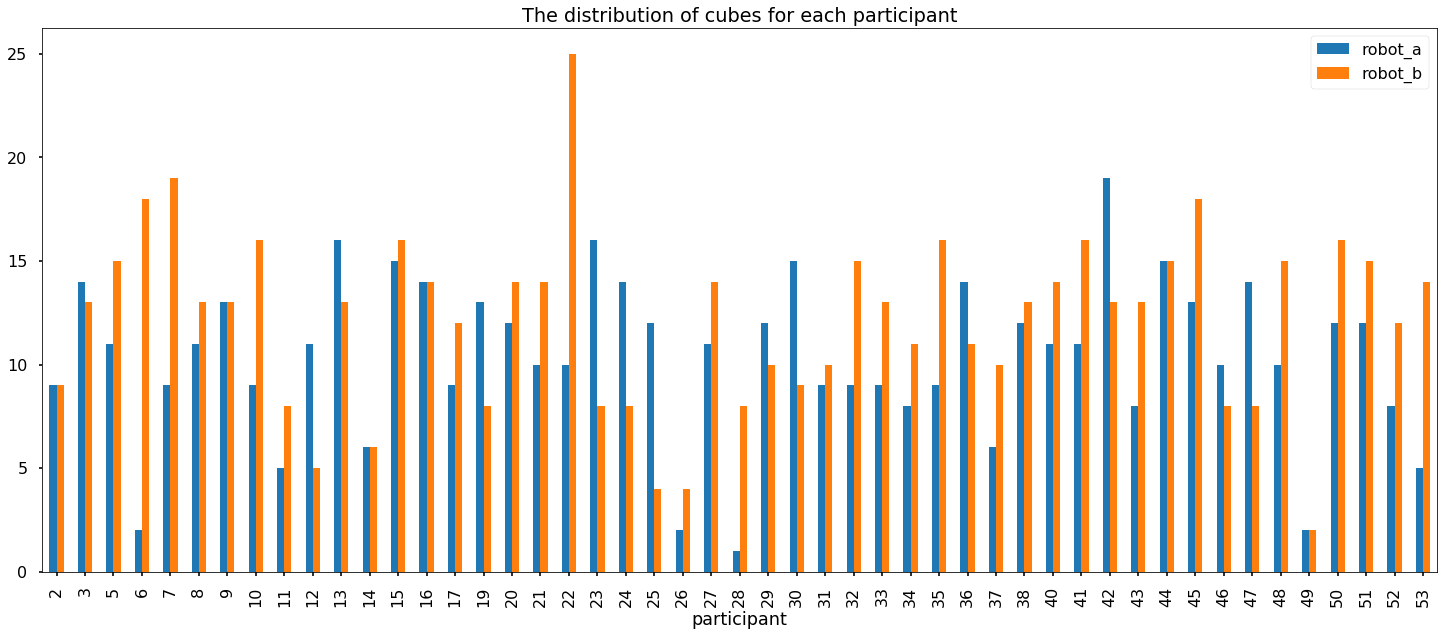

In [0]:
cubes_per_participant[['robot_a', 'robot_b']].plot(kind = 'bar', yticks=range(0, 30, 5), figsize=(25,10), title="The distribution of cubes for each participant")

Box plots for robot A and robot B:

Text(0.5, 0.98, 'Box plots for robot A and robot B')

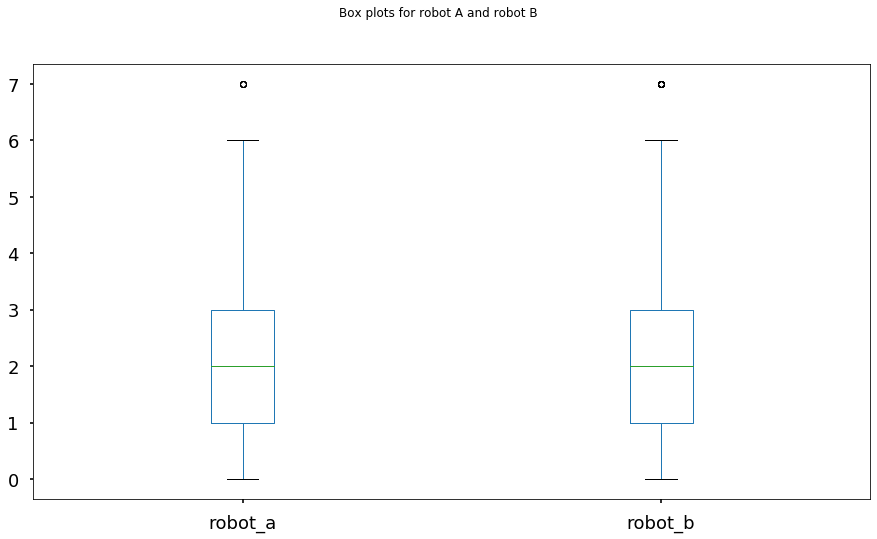

In [0]:
axes = raw_data.boxplot(column=['robot_a', 'robot_b'], figsize=(15,8), fontsize=18, grid=False)
fig = axes.get_figure()
fig.suptitle('Box plots for robot A and robot B')

Boxplots for robot A and robot B grouped by NVC, e.g. the left plot means that 
A is an NVC-robot:

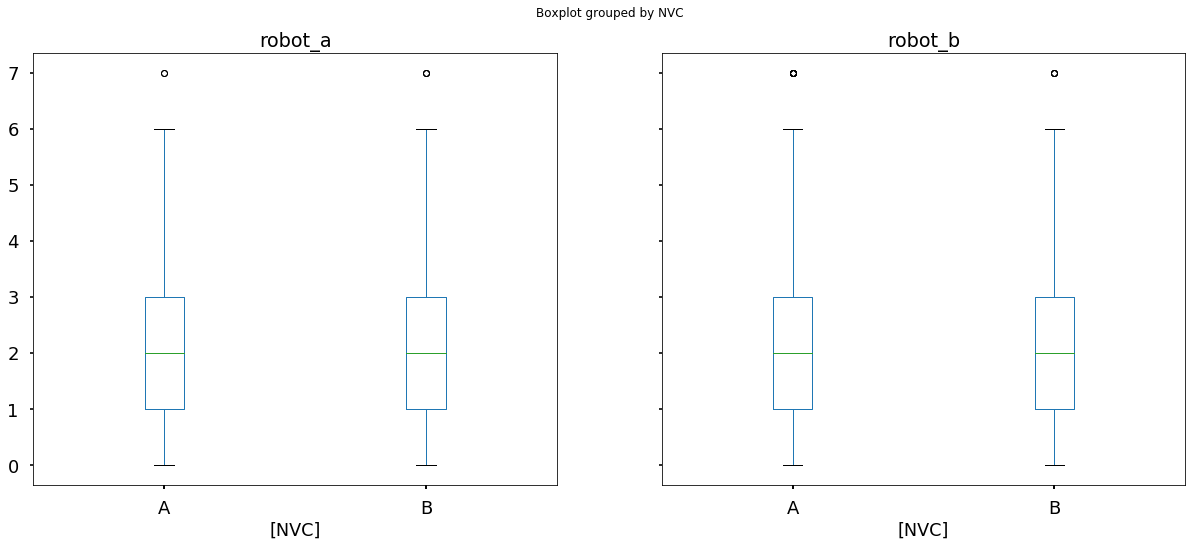

In [0]:
axes = raw_data[['robot_a', 'robot_b', 'NVC']].boxplot(by='NVC', figsize=(20,8), fontsize=18, grid=False)

Boxplots for robot A and robot B grouped by scene:


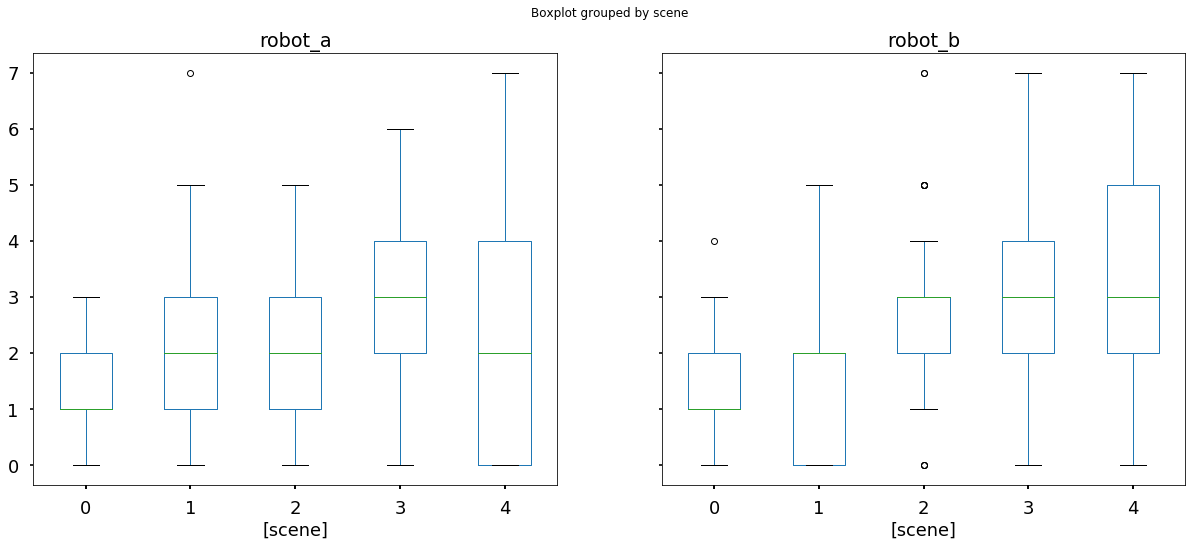

In [0]:
axes = raw_data[['robot_a', 'robot_b', 'scene']].boxplot(by='scene', figsize=(20,8), fontsize=18, grid=False)

Histogram of allocated cubes for robot A and robot B:

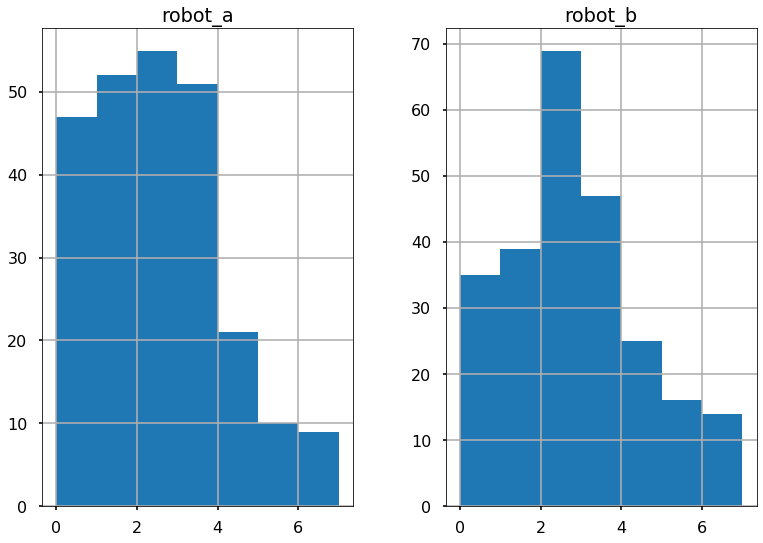

In [0]:
hist = raw_data[['robot_a', 'robot_b']].hist(bins=7)

Histogram of allocated cubes for robot A and robot B grouped by NVC. The plot on the left means taht A is NVC-robot. Plot on the right means that B is non-NVC robot:

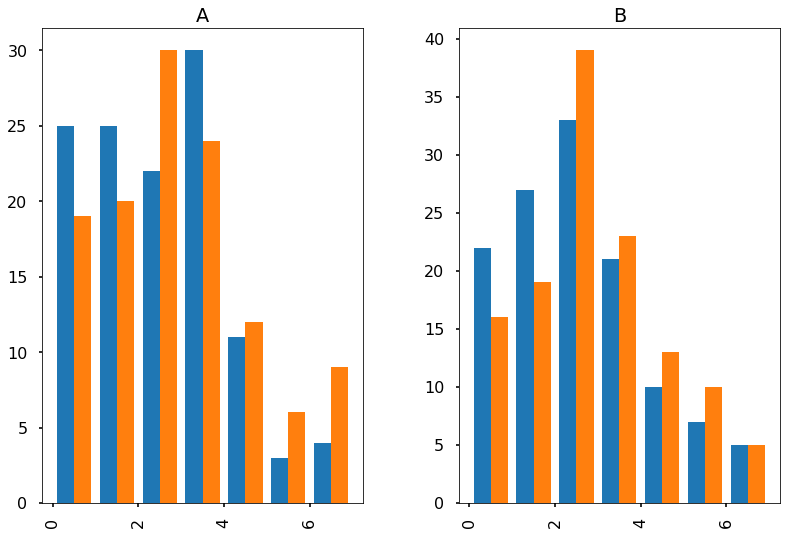

In [0]:
hist = raw_data[['robot_a', 'robot_b', 'NVC']].hist(bins=7, by='NVC')

Density plot considering the number of allocated cubes for robot A and robot B:

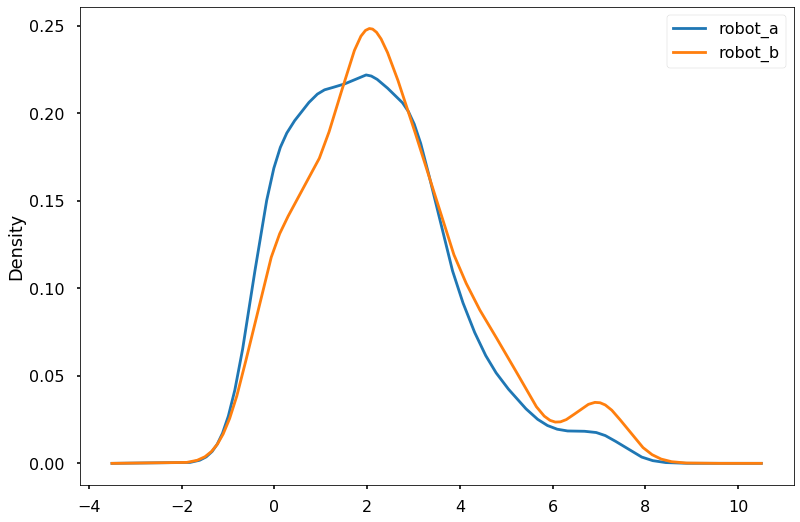

In [0]:
raw_data[['robot_a', 'robot_b']].plot.kde()

The number of allocated cubes of selected participants for each scene (Robot A):

[[<matplotlib.axis.XTick at 0x7f04edd4d320>,

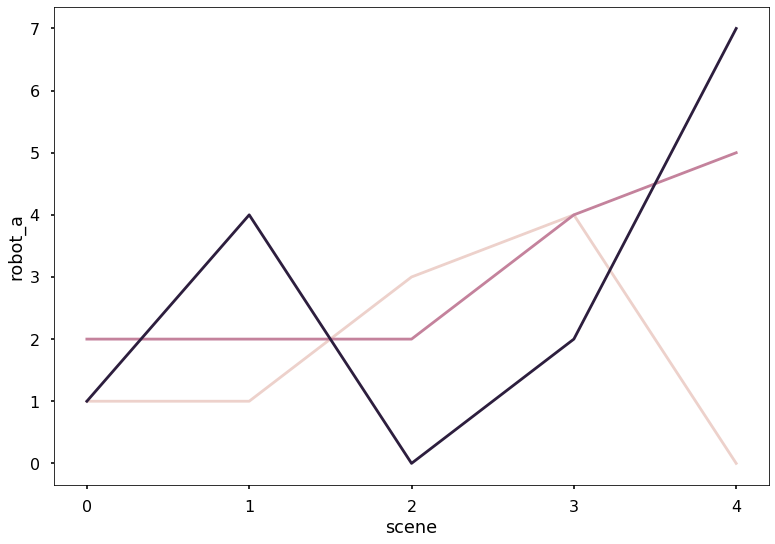

In [0]:
import random
random_participants = random.sample(range(10, 30), 3)
participants_data = raw_data[raw_data['participant'].isin(random_participants)]
ax = sns.lineplot(x="scene", y="robot_a", hue="participant", data=participants_data, legend=False)
ax.set(xticks=[0, 1, 2, 3, 4])

The number of allocated cubes of selected participants for each scene (Robot B):

[[<matplotlib.axis.XTick at 0x7f04edcbe3c8>,

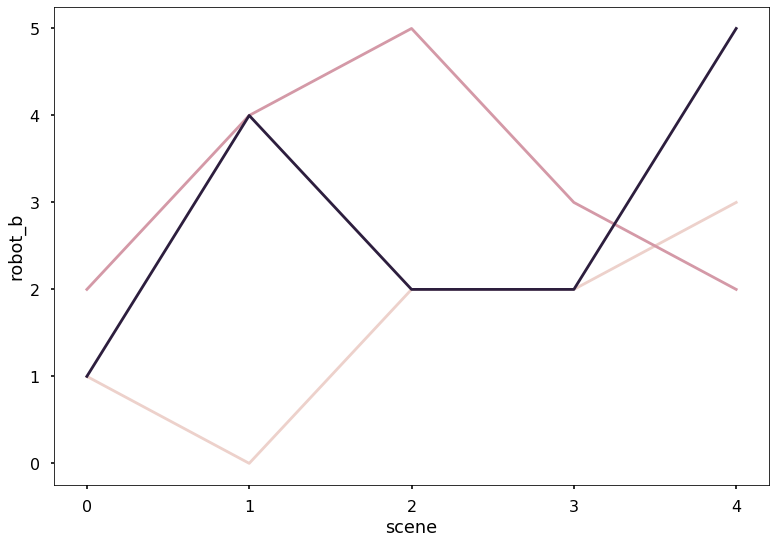

In [0]:
import random
random_participants = random.sample(range(10, 30), 3)
participants_data = raw_data[raw_data['participant'].isin(random_participants)]
ax = sns.lineplot(x="scene", y="robot_b", hue="participant", data=participants_data, legend=False)
ax.set(xticks=[0, 1, 2, 3, 4])

### **Distribution of cubes allocation for each scene**
---

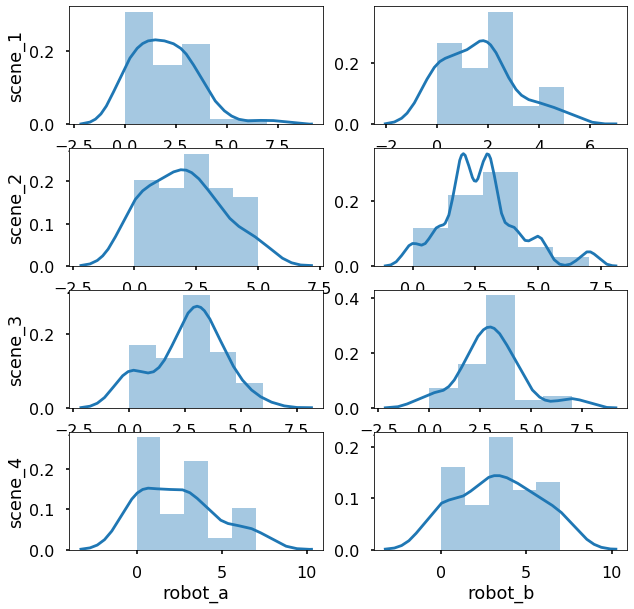

In [0]:
df_scene_1 = raw_data[(raw_data["scene"] == 1)]
df_scene_2 = raw_data[(raw_data["scene"] == 2)]
df_scene_3 = raw_data[(raw_data["scene"] == 3)]
df_scene_4 = raw_data[(raw_data["scene"] == 4)]
# df_scene_1[["robot_a","robot_b"]].hist(bins=5,alpha=0.3)

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,10))

ax[0][0].set_ylabel("scene_1")
ax[1][0].set_ylabel("scene_2")
ax[2][0].set_ylabel("scene_3")
ax[3][0].set_ylabel("scene_4")
sns.distplot(df_scene_1["robot_a"], bins=5, ax=ax[0][0])
sns.distplot(df_scene_1["robot_b"], bins=5, ax=ax[0][1])
sns.distplot(df_scene_2["robot_a"], bins=5, ax=ax[1][0])
sns.distplot(df_scene_2["robot_b"], bins=5, ax=ax[1][1])
sns.distplot(df_scene_3["robot_a"], bins=5, ax=ax[2][0])
sns.distplot(df_scene_3["robot_b"], bins=5, ax=ax[2][1])
sns.distplot(df_scene_4["robot_a"], bins=5, ax=ax[3][0])
sns.distplot(df_scene_4["robot_b"], bins=5, ax=ax[3][1])

### Cubes allocation distribution for each scene

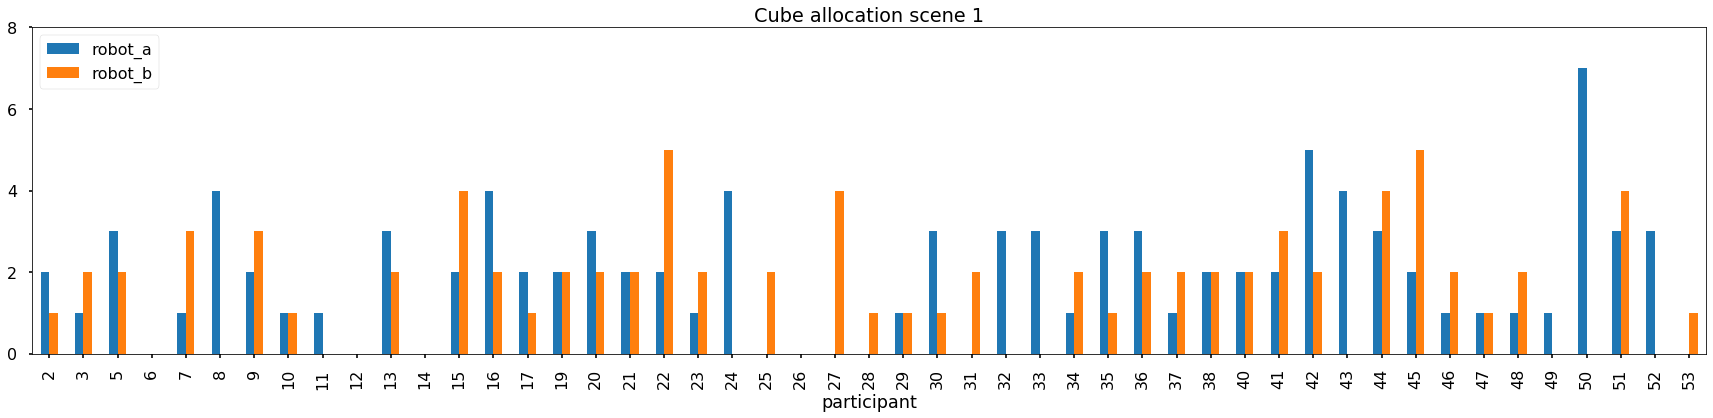

In [0]:
scene = 1
temp = raw_data[raw_data["scene"] == scene]
cubes_by_participant_scenes_1 = temp.groupby(["participant"]).sum()
cubes_by_participant_scenes_1[["robot_a","robot_b"]].plot(kind = 'bar', yticks=range(0, 10, 2), figsize=(30,6), title="Cube allocation scene {}".format(scene))

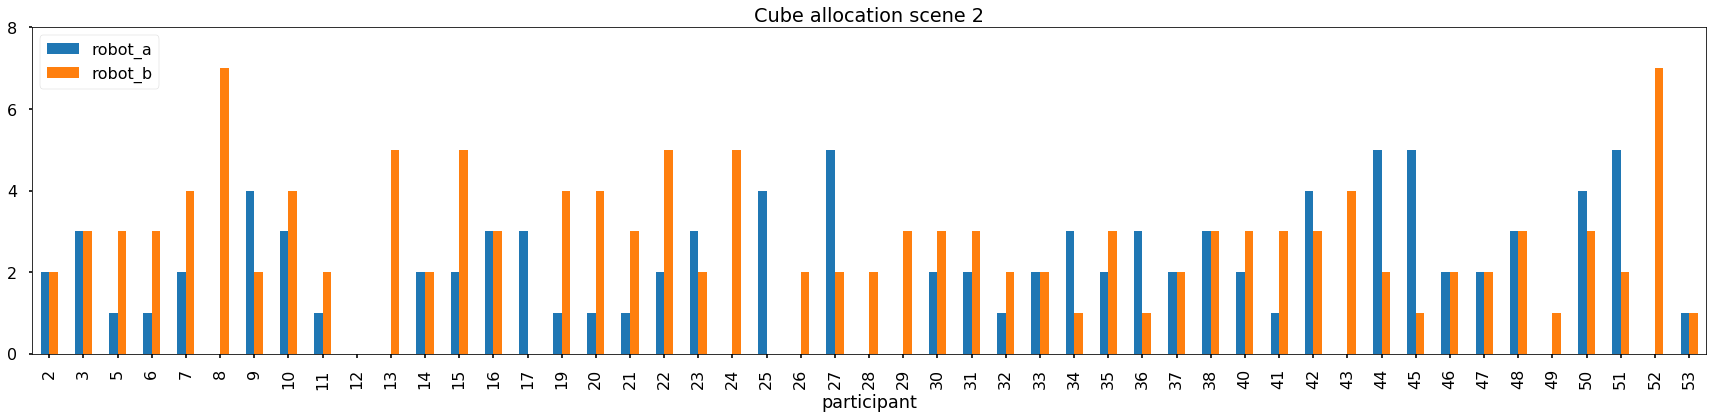

In [0]:
scene = 2
temp = raw_data[raw_data["scene"] == scene]
cubes_by_participant_scenes_1 = temp.groupby(["participant"]).sum()
cubes_by_participant_scenes_1[["robot_a","robot_b"]].plot(kind = 'bar', yticks=range(0, 10, 2), figsize=(30,6), title="Cube allocation scene {}".format(scene))

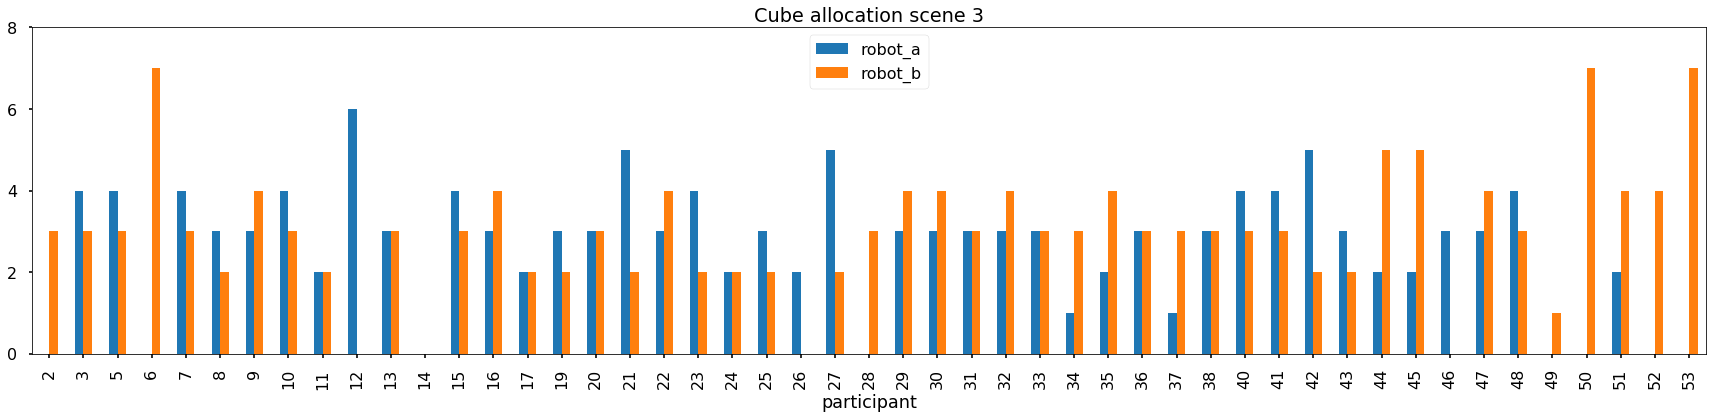

In [0]:
scene = 3
temp = raw_data[raw_data["scene"] == scene]
cubes_by_participant_scenes_1 = temp.groupby(["participant"]).sum()
cubes_by_participant_scenes_1[["robot_a","robot_b"]].plot(kind = 'bar', yticks=range(0, 10, 2), figsize=(30,6), title="Cube allocation scene {}".format(scene))

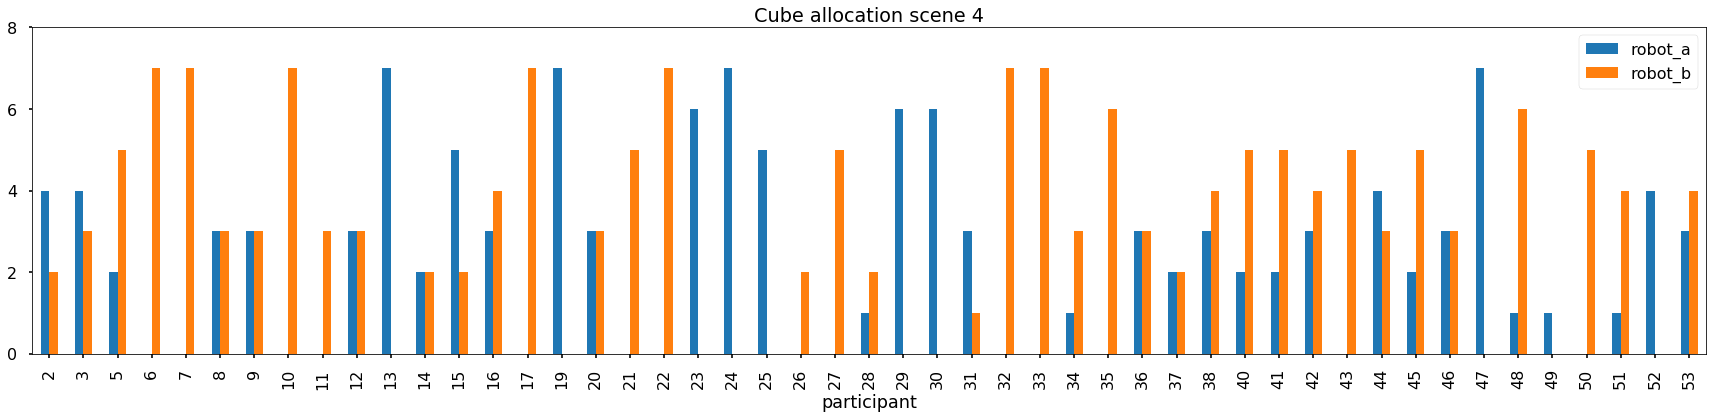

In [0]:
scene = 4
temp = raw_data[raw_data["scene"] == scene]
cubes_by_participant_scenes_1 = temp.groupby(["participant"]).sum()
cubes_by_participant_scenes_1[["robot_a","robot_b"]].plot(kind = 'bar', yticks=range(0, 10, 2), figsize=(30,6), title="Cube allocation scene {}".format(scene))

# **Statistical Test H1: "NVC impacts cubes allocation"**
---

# Trend Checking for alternate cube allocation behavior

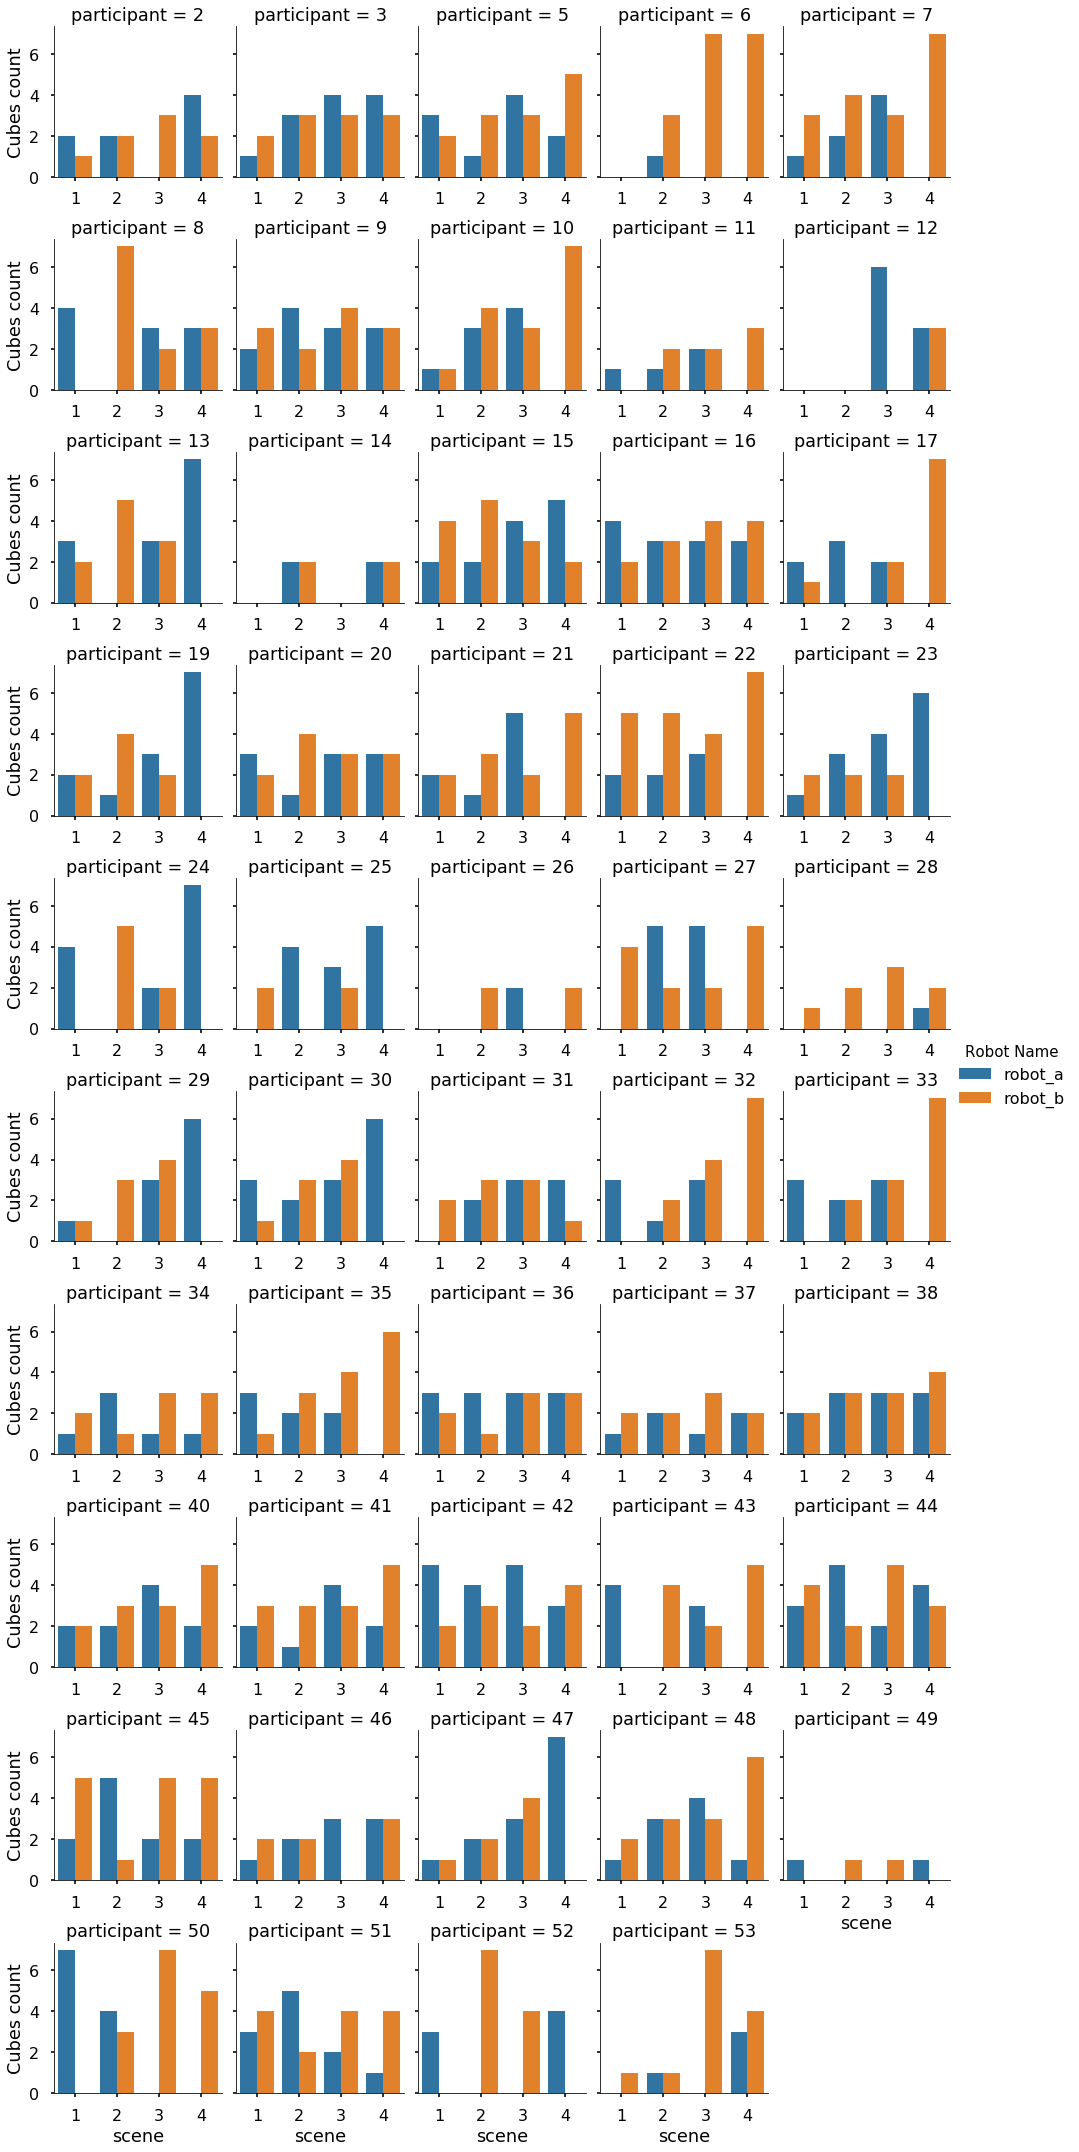

In [0]:
# Only from scene 1 to 4
filtered_data = raw_data[raw_data["scene"] > 0]

fabricated_data = pd.melt(filtered_data, id_vars=['scene', 'participant'], value_vars=['robot_a', 'robot_b'],
        var_name='Robot Name', value_name='Cubes count')
sns.catplot(x='scene', y='Cubes count', hue='Robot Name', col='participant', kind='bar', data=fabricated_data, col_wrap=5, height=3, aspect=0.9, sharex=False)

In [0]:
participant_preferred_B = filtered_data.query('scene==2 and robot_b > robot_a')['participant']
participant_preferred_A = filtered_data.query('scene==2 and robot_a > robot_b')['participant']
participant_preferred_both = filtered_data.query('scene==2 and robot_a == robot_b and robot_a>0')['participant']
participant_preferred_none = filtered_data.query('scene==2 and robot_a == robot_b and robot_a==0')['participant']

def get_allocation_count_in_next_scene(scene_no, prev_scene_allocation):
  preferred_A = filtered_data.query('scene==@scene_no and robot_a > robot_b and participant in @prev_scene_allocation')['participant']
  preferred_B = filtered_data.query('scene==@scene_no and robot_b > robot_a and participant in @prev_scene_allocation')['participant']
  preferred_Both = filtered_data.query('scene==@scene_no and robot_a == robot_b and robot_b>0 and participant in @prev_scene_allocation')['participant']
  preferred_None = filtered_data.query('scene==@scene_no and robot_a == robot_b and robot_b==0 and participant in @prev_scene_allocation')['participant']
  return [preferred_A.count(), preferred_B.count(), preferred_Both.count(), preferred_None.count()]

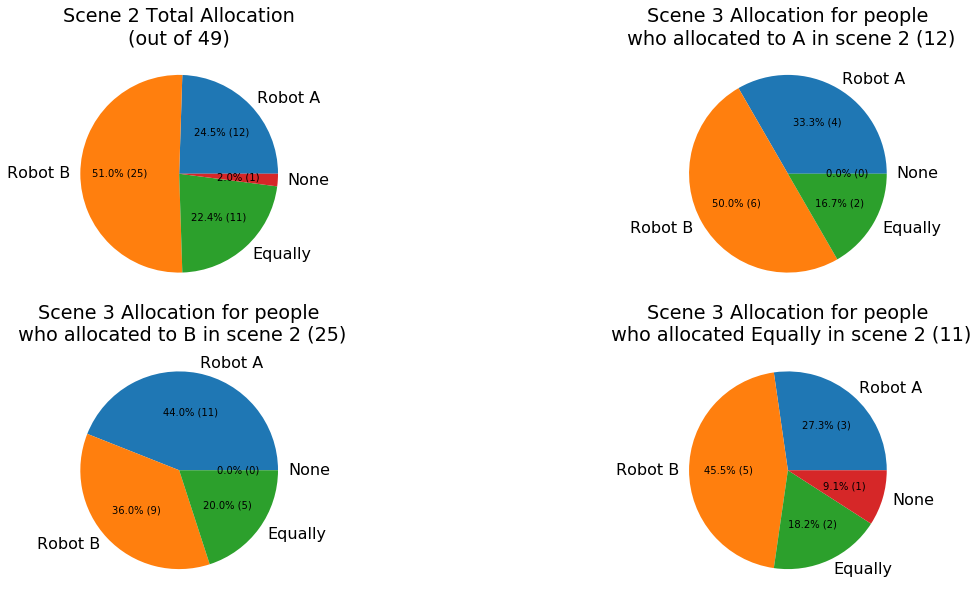

In [0]:
def make_autopct(values):
    def autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}% ({v:d})'.format(p=pct,v=val)
    return autopct

vals = np.array([get_allocation_count_in_next_scene(3, participant_preferred_A),
                 get_allocation_count_in_next_scene(3, participant_preferred_B),
                 get_allocation_count_in_next_scene(3, participant_preferred_both),
                 get_allocation_count_in_next_scene(3, participant_preferred_none)
                 ])
labels = ['Robot A', 'Robot B', 'Equally', 'None']
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax[0][0].pie(vals.sum(axis=1), radius=1, labels=labels, autopct=make_autopct(vals.sum(axis=1)))
ax[0][0].set(aspect="equal")
ax[0][0].set_title("Scene 2 Total Allocation\n(out of "+str(vals.sum())+")")
ax[0][1].pie(vals[0], radius=1, labels=labels, autopct=make_autopct(vals[0]))
ax[0][1].set(aspect="equal")
ax[0][1].set_title("Scene 3 Allocation for people\n who allocated to A in scene 2 ("+str(vals[0].sum())+")")
ax[1][0].pie(vals[1], radius=1, labels=labels, autopct=make_autopct(vals[1]))
ax[1][0].set(aspect="equal")
ax[1][0].set_title("Scene 3 Allocation for people\n who allocated to B in scene 2 ("+str(vals[1].sum())+")")
ax[1][1].pie(vals[2], radius=1, labels=labels, autopct=make_autopct(vals[2]))
ax[1][1].set(aspect="equal")
ax[1][1].set_title("Scene 3 Allocation for people\n who allocated Equally in scene 2 ("+str(vals[2].sum())+")")
plt.show()

**From this section, following conclusions can be drawn**
1. In scene 2, robot B is preferred(25/49) and out of those 25 people, 16 either switched to robot A or gave them equally in scene 3(5 gave them equally).
2. In scene 2, out of people who preferred robot A(12/35), 8 either switched to robot B or gave them equally in scene 3(2 gave them equally).

## Sub hypothesis: Set of questions asked by participant does not influence cubes allocation

## Sub hypothesis: Speech content does not influence cubes allocation

One Sample Wilcoxon Sign Test
___

H0: There is no different between content A and B <br>
H1: There is different

In [0]:
print(f'Two-sided: {stats.wilcoxon(raw_data["allocation_metric"])}')
print(f'One-tailed Greater: {stats.wilcoxon(raw_data["allocation_metric"], alternative="greater")}')
print(f'One-tailed Less: {stats.wilcoxon(raw_data["allocation_metric"], alternative="less")}')

Two-sided: WilcoxonResult(statistic=5027.0, pvalue=0.02085133119860404)
One-tailed Greater: WilcoxonResult(statistic=7693.0, pvalue=0.01042566559930202)
One-tailed Less: WilcoxonResult(statistic=7693.0, pvalue=0.989574334400698)


In [0]:
df_scene = raw_data[raw_data['scene']==1]
print(f'Two-sided: {stats.wilcoxon(raw_data["allocation_metric"])}')
print(f'One-tailed Greater: {stats.wilcoxon(raw_data["allocation_metric"], alternative="greater")}')
print(f'One-tailed Less: {stats.wilcoxon(raw_data["allocation_metric"], alternative="less")}')

Two-sided: WilcoxonResult(statistic=5027.0, pvalue=0.02085133119860404)
One-tailed Greater: WilcoxonResult(statistic=7693.0, pvalue=0.01042566559930202)
One-tailed Less: WilcoxonResult(statistic=7693.0, pvalue=0.989574334400698)


In [0]:
df_scene = raw_data["allocation_metric"]
print(f'Two-sided: {stats.wilcoxon(raw_data["allocation_metric"])}')
print(f'One-tailed Greater: {stats.wilcoxon(raw_data["allocation_metric"], alternative="greater")}')
print(f'One-tailed Less: {stats.wilcoxon(raw_data["allocation_metric"], alternative="less")}')

Two-sided: WilcoxonResult(statistic=5027.0, pvalue=0.02085133119860404)
One-tailed Greater: WilcoxonResult(statistic=7693.0, pvalue=0.01042566559930202)
One-tailed Less: WilcoxonResult(statistic=7693.0, pvalue=0.989574334400698)


In [0]:
print(f'Two-sided: {stats.wilcoxon(raw_data["allocation_metric"])}')
print(f'One-tailed Greater: {stats.wilcoxon(raw_data["allocation_metric"], alternative="greater")}')
print(f'One-tailed Less: {stats.wilcoxon(raw_data["allocation_metric"], alternative="less")}')

Two-sided: WilcoxonResult(statistic=5027.0, pvalue=0.02085133119860404)
One-tailed Greater: WilcoxonResult(statistic=7693.0, pvalue=0.01042566559930202)
One-tailed Less: WilcoxonResult(statistic=7693.0, pvalue=0.989574334400698)


Wilcoxon Ranked Sum Test
___

***h0: there is no different between content A and content B***

***h1: there is different***

In [0]:
def get_speech_content_groups(scene=None):
  
  # if scene not mentioned, take the aggregation of mean of allocation metric
  if not scene:
    df_mean = raw_data.groupby("participant")["allocation_metric"].mean()
    group_a = df_mean < 0
    group_a = np.abs(group_a) # take out the negative value
    group_b = df_mean > 0
    return group_a, group_b

  df_scene = raw_data[raw_data["scene"] == scene]
  group_a = df_scene[df_scene["allocation_metric"] < 0]["allocation_metric"]
  group_a = np.abs(group_a) # take out the negative value

  group_b = df_scene[df_scene["allocation_metric"] < 0]["allocation_metric"]
  return group_a, group_b

In [0]:
print("Scene 1: ", stats.ranksums(*get_speech_content_groups(scene=1)))
print("Scene 2: ", stats.ranksums(*get_speech_content_groups(scene=2)))
print("Scene 3: ", stats.ranksums(*get_speech_content_groups(scene=3)))
print("Scene 4: ", stats.ranksums(*get_speech_content_groups(scene=4)))
print("Mean by Participant: ", stats.ranksums(*get_speech_content_groups()))

Scene 1:  RanksumsResult(statistic=5.269651864139676, pvalue=1.366827462388243e-07)
Scene 2:  RanksumsResult(statistic=4.156921938165305, pvalue=3.225641456243767e-05)
Scene 3:  RanksumsResult(statistic=5.269651864139676, pvalue=1.366827462388243e-07)
Scene 4:  RanksumsResult(statistic=4.666282626286914, pvalue=3.0669777654622667e-06)
Mean by Participant:  RanksumsResult(statistic=-2.785242495291165, pvalue=0.005348770520482036)


## Sub hypothesis: Robot's face color does not influence cube allocation

###Separating the data for eye color

In [0]:
swap_heads_id = 26

def separate_red_yellow_eyes_data(data, swap_heads_id):
    red_eye_on_A = data[data['participant'] <= swap_heads_id]
    yellow_eye_on_A = data[data['participant'] > swap_heads_id]
    
    return red_eye_on_A, yellow_eye_on_A

### Separating data for NVC and non NVCs

In [0]:
## separates nv and non nvc data with scene number > scene_num
def separate_NVC_nonNVC(data, scene_num):
    odd_participants_data = data[data["participant"] % 2 != 0]
    odd_participants_data = odd_participants_data[odd_participants_data["scene"] > scene_num]
    
    even_participants_data = data[data["participant"] % 2 == 0]
    even_participants_data = even_participants_data[even_participants_data["scene"] > scene_num]
    
    return even_participants_data, odd_participants_data

In [0]:
## takes a list of colums to be dropped and return clean data
def drop_colums(data, column_list):
    clean_data = data.drop(columns=column_list)
    return clean_data

In [0]:
## takes a list of column names and group them
def group_data(data, group_list):
    groupped_data = data.groupby(group_list).sum()
    return groupped_data

### Separating data scene wise

In [0]:
def separate_data_scene_wise(data):
    data_1 = data[(data["scene"] == 1)]
    data_2 = data[(data["scene"] == 2)]
    data_3 = data[(data["scene"] == 3)]
    data_4 = data[(data["scene"] == 4)]
    
    return data_1, data_2, data_3, data_4

In [0]:
red_on_A, red_on_B = separate_red_yellow_eyes_data(raw_data, swap_heads_id)

In [0]:
red_on_B_s1, red_on_B_s2, red_on_B_s3, red_on_B_s4 = separate_data_scene_wise(red_on_B)

In [0]:
red_on_A_s1, red_on_A_s2, red_on_A_s3, red_on_A_s4 = separate_data_scene_wise(red_on_A)

In [0]:
red_on_A = drop_colums(red_on_A, ['NVC_A','NVC_B', 'NVC'])
red_on_A = red_on_A[red_on_A['scene'] > 0]
red_on_A = group_data(red_on_A,['participant'])
red_on_A = drop_colums(red_on_A, ['scene'])
red_on_A['allocation_metric'] = red_on_A['allocation_metric'] / 4
red_on_A.head()

,robot_a,robot_b,allocation_metric,head_group
participant,,,,
2,8,8,0.083333,0
3,12,11,0.011905,0
5,10,13,0.146429,0
6,1,17,0.625000,0
7,7,17,0.422619,0


In [0]:
red_on_B = drop_colums(red_on_B, ['NVC_A','NVC_B', 'NVC'])
red_on_B = red_on_B[red_on_B['scene'] > 0]
red_on_B = group_data(red_on_B,['participant'])
red_on_B = drop_colums(red_on_B, ['scene'])
red_on_B['allocation_metric'] = red_on_B['allocation_metric'] / 4
red_on_B.head()

,robot_a,robot_b,allocation_metric,head_group
participant,,,,
27,10,13,0.285714,4
28,1,8,0.833333,4
29,10,8,0.035714,4
30,14,8,-0.289286,4
31,8,9,0.175000,4


In [0]:
red_on_B

,robot_a,robot_b,allocation_metric,head_group
participant,,,,
27,10,13,0.285714,4
28,1,8,0.833333,4
29,10,8,0.035714,4
30,14,8,-0.289286,4
31,8,9,0.175000,4
32,7,13,0.119048,4
33,8,12,0.000000,4
34,6,9,0.208333,4
35,7,14,0.258333,4


In [0]:
ranksum_colum = 'allocation_metric'
print("Scene 1: ", wilcoxon_ranksum_test(red_on_A_s1, red_on_B_s1, ranksum_colum))
print("Scene 2: ", wilcoxon_ranksum_test(red_on_A_s2, red_on_B_s2, ranksum_colum))
print("Scene 3: ", wilcoxon_ranksum_test(red_on_A_s3, red_on_B_s3, ranksum_colum))
print("Scene 4: ", wilcoxon_ranksum_test(red_on_A_s4, red_on_B_s4, ranksum_colum))
print("Mean by Participant: ", wilcoxon_ranksum_test(red_on_A, red_on_B, ranksum_colum))

NameError: ignored

## Multivariate Speech Content + Face Color (Head Group)

In [0]:
import statsmodels.formula.api as smf

In [0]:
model = smf.ols(formula="allocation_metric ~ C(head_group)", data=raw_data).fit()
model.summary()

## Main Hypothesis: "NVC cube allocation > NNVC"

One Sample Wilcoxon (When A is NVC)
___

In [0]:
df_nvc_a = raw_data[(raw_data["NVC_A"] == True) & (raw_data["scene"] != 0)]
df_nvc_a_mean = df_nvc_b.groupby(["participant"]).mean()["allocation_metric"]

print(f'One-tailed Greater: {stats.wilcoxon(df_nvc_a_mean, alternative="greater")}')

**Explaination**: When A is NVC, we expect people give more cubes to Robot A. We evaluate this by using one sample wilcoxon with <br>
h0: the mean of allocation metric >= 0 <br>
h1: the mean of allocation metric < 0 (because full trust on A, allocation metric will be is -1)

In [0]:
df_nvc_a_scene_1, df_nvc_a_scene_2, df_nvc_a_scene_3, df_nvc_a_scene_4 = separate_data_scene_wise(df_nvc_a)
print(f'Scene 1 One-tailed Greater: {stats.wilcoxon(df_nvc_a_scene_1["allocation_metric"], alternative="less")}')
print(f'Scene 2 One-tailed Greater: {stats.wilcoxon(df_nvc_a_scene_2["allocation_metric"], alternative="less")}')
print(f'Scene 3 One-tailed Greater: {stats.wilcoxon(df_nvc_a_scene_3["allocation_metric"], alternative="less")}')
print(f'Scene 4 One-tailed Greater: {stats.wilcoxon(df_nvc_a_scene_4["allocation_metric"], alternative="less")}')

One Sample Wilcoxon (When B is NVC)
___

In [0]:
df_nvc_b = raw_data[(raw_data["NVC_B"] == True) & (raw_data["scene"] != 0)]
df_nvc_b_mean = df_nvc_b.groupby(["participant"]).mean()["allocation_metric"]

print(f'One-tailed Greater: {stats.wilcoxon(df_nvc_b_mean, alternative="greater")}')

**Explaination**: When B is NVC, we expect people give more cubes to Robot B. We evaluate this by using one sample wilcoxon with <br>
h0: the mean of allocation metric <= 0 <br>
h1: the mean of allocation metric > 0 (because full trust on B, allocation metric will be is 1)

In [0]:
df_nvc_b_scene_1, df_nvc_b_scene_2, df_nvc_b_scene_3, df_nvc_b_scene_4 = separate_data_scene_wise(df_nvc_b)
print(f'Scene 1 One-tailed Greater: {stats.wilcoxon(df_nvc_b_scene_1["allocation_metric"], alternative="greater")}')
print(f'Scene 2 One-tailed Greater: {stats.wilcoxon(df_nvc_b_scene_2["allocation_metric"], alternative="greater")}')
print(f'Scene 3 One-tailed Greater: {stats.wilcoxon(df_nvc_b_scene_3["allocation_metric"], alternative="greater")}')
print(f'Scene 4 One-tailed Greater: {stats.wilcoxon(df_nvc_b_scene_4["allocation_metric"], alternative="greater")}')

Clearly we see that people tend to trust B on scene 2

H0: There is no different NVC and NNVC <br>
H1: NVC > NNVC

*Pair t-test*
---
___

*Scene 1*

In [0]:
stat.ttest_rel(df_scene_1["robot_a"], df_scene_1["robot_b"])

*Scene 2*

In [0]:
 stat.ttest_rel(df_scene_2["robot_a"], df_scene_2["robot_b"])

Scene 3

In [0]:
stat.ttest_rel(df_scene_3["robot_a"], df_scene_3["robot_b"])

Scene 4

In [0]:
stat.ttest_rel(df_scene_4["robot_a"], df_scene_4["robot_b"])

***Conclusion***

*p-value >= 0.05, **accept h0:** There is no different between Robot A and Robot B in Scene 1,3,4*

*p-value < 0.05 t < 0, **accept h1:** robot a < robot b in scene 2*

### **Paired t-test to test the difference between NVC and non-NVC robots per scene**

In [0]:
data_nvc_a = raw_data[raw_data['NVC_A'] == True]
data_nvc_a = data_nvc_a[['scene', 'robot_a', 'robot_b']]
data_nvc_a.head()

In [0]:
data_nvc_b = raw_data[raw_data['NVC_B'] == True]
data_nvc_b = data_nvc_b[['scene', 'robot_a', 'robot_b']]
data_nvc_b.head()

In [0]:
scene = 1
res_a_nvc = stats.ttest_rel(data_nvc_a[data_nvc_a['scene'] == scene]["robot_a"], data_nvc_a[data_nvc_a['scene'] == scene]["robot_b"])
res_b_nvc = stats.ttest_rel(data_nvc_b[data_nvc_b['scene'] == scene]["robot_a"], data_nvc_b[data_nvc_b['scene'] == scene]["robot_b"])
print(res_a_nvc)
print(res_b_nvc)

In [0]:
scene = 2
res_a_nvc = stats.ttest_rel(data_nvc_a[data_nvc_a['scene'] == scene]["robot_a"], data_nvc_a[data_nvc_a['scene'] == scene]["robot_b"])
res_b_nvc = stats.ttest_rel(data_nvc_b[data_nvc_b['scene'] == scene]["robot_a"], data_nvc_b[data_nvc_b['scene'] == scene]["robot_b"])
print(res_a_nvc)
print(res_b_nvc)

In [0]:
scene = 3
res_a_nvc = stats.ttest_rel(data_nvc_a[data_nvc_a['scene'] == scene]["robot_a"], data_nvc_a[data_nvc_a['scene'] == scene]["robot_b"])
res_b_nvc = stats.ttest_rel(data_nvc_b[data_nvc_b['scene'] == scene]["robot_a"], data_nvc_b[data_nvc_b['scene'] == scene]["robot_b"])
print(res_a_nvc)
print(res_b_nvc)

In [0]:
scene = 4
res_a_nvc = stats.ttest_rel(data_nvc_a[data_nvc_a['scene'] == scene]["robot_a"], data_nvc_a[data_nvc_a['scene'] == scene]["robot_b"])
res_b_nvc = stats.ttest_rel(data_nvc_b[data_nvc_b['scene'] == scene]["robot_a"], data_nvc_b[data_nvc_b['scene'] == scene]["robot_b"])
print(res_a_nvc)
print(res_b_nvc)

## Conclusion: when the robot A is an NVC-robot in scene 2 there is a difference between expected values of A and B. B is preferred.

###Wilcoxon, pair t test and wilcoxon rank sum test functions

In [0]:
#takes data and list of column names
#wilcoxon_test(red_eye, ['robot_a', 'robot_b'])
def wilcoxon_test(data, column_names):
    return stats.wilcoxon(data[column_names[0]], data[column_names[1]])

In [0]:
#takes data and list of column names
#pair_t_test(red_eye, ['robot_a', 'robot_b'])
def pair_t_test(data, column_names):
    return stats.ttest_rel(data[column_names[0]], data[column_names[1]])

In [0]:
##takes two data and compare their same colum  
def wilcoxon_ranksum_test(data1, data2, column):
    return stats.ranksums(data1[column], data2[column])

In [0]:
ranksum_colum = 'allocation_metric'
print(wilcoxon_ranksum_test(red_on_A_s1, red_on_B_s1, ranksum_colum))
print(wilcoxon_ranksum_test(red_on_A_s2, red_on_B_s2, ranksum_colum))
print(wilcoxon_ranksum_test(red_on_A_s3, red_on_B_s3, ranksum_colum))
print(wilcoxon_ranksum_test(red_on_A_s4, red_on_B_s4, ranksum_colum))
print(wilcoxon_ranksum_test(red_on_A, red_on_B, ranksum_colum))

# **Correlation of cubes allocation between 2 robots**

In [0]:
raw_data[["robot_a","robot_b"]].corr()

# **Calculating the significance of allocated cubes as:**
---
*the number of allocated cubes to one robot divided by the sum of allocated cubes to both robots*

In [0]:
approach1 = raw_data.copy()
approach1["sum_cubes_a_and_b"] = approach1["robot_a"] + approach1["robot_b"]
approach1["significance_A"] = approach1["robot_a"] / approach1["sum_cubes_a_and_b"]
approach1["significance_B"] = approach1["robot_b"] / approach1["sum_cubes_a_and_b"]
approach1.head()

In [0]:
data_nvc_a = raw_data[raw_data['NVC'] == 'A']
data_nvc_a = data_nvc_a[['scene', 'robot_a', 'robot_b']]
data_nvc_a.head()

*Significance of robots in each scene*
---
___

In [0]:
approach1_plot_data = approach1.groupby(['scene']).mean()
approach1_plot_data = approach1_plot_data[['significance_A', 'significance_B']]
approach1_plot_data

In [0]:
 approach1_plot_data.plot(kind='bar', figsize=(20,10), title='The significance of robots considering a scene')

*Significance of robots with & without NVC in each scene*
---
___

In [0]:
approach1_plot_data = approach1.groupby(['scene', 'NVC']).mean()
approach1_plot_data = approach1_plot_data[['significance_A', 'significance_B']]
approach1_plot_data

In [0]:
 approach1_plot_data.plot(kind='bar', figsize=(20,10), title='The significance of robots considering a scene and if a robot NVC or not')

In [0]:
def get_significance(row):
   if row['NVC'] == 'A' :
      return row['significance_A']
   if row['NVC'] == 'B' :
      return row['significance_B']
   return 0.0
approach1['significance'] = approach1.apply(lambda row: get_significance(row), axis=1)

In [0]:
data_corr = approach1[approach1['scene']==2]
data_corr = data_corr[['NVC','significance']]
data_corr.NVC = pd.Categorical(data_corr.NVC)
data_corr['NVC_encoded'] = data_corr.NVC.cat.codes
data_corr.corr()

# **Personality type and NVC**

In [0]:
questionnaire_data = df.copy()
questionnaire_data = questionnaire_data[questionnaire_data.iloc[:,6] < 54]
personality_data = questionnaire_data.iloc[:,6:30]
personality_data = personality_data.drop(personality_data.columns[[1,2,3,4,5,6,7,8]], axis=1)
personality_data.columns = ['participant', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15']
cols_to_check = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15']
personality_data[cols_to_check] = personality_data[cols_to_check].replace({'A':''}, regex=True)
personality_data = personality_data.apply(pd.to_numeric)

personality_data['Q3'] = 8 - personality_data['Q3']
personality_data['Q6'] = 8 - personality_data['Q6']
personality_data['Q10'] = 8 - personality_data['Q10']
personality_data['Q14'] = 8 - personality_data['Q14']

neuroticism_cols_to_check = ['Q1', 'Q2', 'Q3']
extraversion_cols_to_check = ['Q4', 'Q5', 'Q6']
openness_cols_to_check = ['Q7', 'Q8', 'Q9']
agreeableness_cols_to_check = ['Q10', 'Q11', 'Q12']
conscientiousness_cols_to_check = ['Q13', 'Q14', 'Q15']

# See https://www.oecd.org/skills/piaac/Annex-A-Measures-of-the-big-five-dimensions.pdf
personality_data['neuroticism'] = personality_data[neuroticism_cols_to_check].sum(axis=1)
personality_data['extraversion'] = personality_data[extraversion_cols_to_check].sum(axis=1)
personality_data['openness'] = personality_data[openness_cols_to_check].sum(axis=1)
personality_data['agreeableness'] = personality_data[agreeableness_cols_to_check].sum(axis=1)
personality_data['conscientiousness'] = personality_data[conscientiousness_cols_to_check].sum(axis=1)

pd.set_option('display.max_columns', None)
personality_data = personality_data.set_index("participant")
personality_data = personality_data.iloc[:,15:]
personality_data.tail()
personality_data.tail()

In [0]:
risk_propensity_data = questionnaire_data.iloc[:, [6, 30, 32, 33, 34, 34]]
risk_propensity_data.columns = ['participant', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5']
cols_to_check = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
risk_propensity_data = risk_propensity_data.replace({'A':''}, regex=True)
risk_propensity_data = risk_propensity_data.apply(pd.to_numeric)

risk_propensity_data['Q1'] = 8 - risk_propensity_data['Q1']
risk_propensity_data['Q2'] = 8 - risk_propensity_data['Q2']
risk_propensity_data['Q3'] = 8 - risk_propensity_data['Q3']

risk_propensity_data['risk_propensity'] = risk_propensity_data[cols_to_check].mean(axis=1)

pd.set_option('display.max_columns', None)
risk_propensity_data = risk_propensity_data.set_index("participant")
risk_propensity_data = risk_propensity_data[["risk_propensity"]]
risk_propensity_data.head()

In [0]:
trust_propensity_data = questionnaire_data.iloc[:, [6, 35, 36, 37, 38]]
trust_propensity_data.columns = ['participant', 'Q1', 'Q2', 'Q3', 'Q4']
cols_to_check = ['Q1', 'Q2', 'Q3', 'Q4']
trust_propensity_data = trust_propensity_data.replace({'A':''}, regex=True)
trust_propensity_data = trust_propensity_data.apply(pd.to_numeric)

trust_propensity_data['trust_propensity'] = trust_propensity_data[cols_to_check].mean(axis=1)

pd.set_option('display.max_columns', None)
trust_propensity_data = trust_propensity_data.set_index("participant")
trust_propensity_data = trust_propensity_data.iloc[:,4:]
trust_propensity_data.head()

Correlation between personality types and allocation of cubes for both robots when robot A is an NVC robot

In [0]:
merged_data = pd.merge(personality_data, risk_propensity_data, how='inner', on='participant')
merged_data = pd.merge(merged_data, trust_propensity_data, how='inner', on='participant')
merged_data = merged_data.reset_index()
merged_data.tail()

In [0]:
def run_wilcoxon_test(data, alternative, withScenes=False):
  '''
  Tests if a group A and a group B differ using one sample Wilcoxon test. 
  Do not confuse A and B with robot names.
  Note: we use allocation metric calculated as (B-A)/(B+A) and it means that
  when allocation metric is less than zero participants tend to select
  a robot A
  H0: no difference between two groups
  H1: there is a difference
  '''
  if withScenes:
    for scene in data["scene"].unique().tolist():
        if scene == 0:
            continue
        data = data[data["scene"] == scene]
        print(f'Scene: {scene}')
        print(f'Two-sided: {stats.wilcoxon(data["allocation_metric"])}')
        print(f'Alternative is {alternative}')
        print(f'One-tailed: {stats.wilcoxon(data["allocation_metric"], alternative=alternative)}')
  else:
    print(f'Two-sided: {stats.wilcoxon(data["allocation_metric"])}')
    print(f'Alternative is {alternative}')        
    print(f'One-tailed: {stats.wilcoxon(data["allocation_metric"], alternative=alternative)}')
              
def run_friedman_test(data):
  '''
  '''
  output = stats.friedmanchisquare(data[data["scene"]==0]["allocation_metric"],
                                             data[data["scene"]==1]["allocation_metric"],
                                             data[data["scene"]==2]["allocation_metric"],
                                             data[data["scene"]==3]["allocation_metric"],
                                             data[data["scene"]==4]["allocation_metric"])
  print(output)
  return output
    
def get_relevant_participants(data, column, top_k=20, largest=True):
    w_data = data.copy()
    if largest:
        w_data = w_data.nlargest(top_k, column)
    else: 
        w_data = w_data.nsmallest(top_k, column)
    w_data = w_data["participant"].tolist()   
    return w_data
        
def select_data(data, participants, nvc_robot='NVC_A'):
    w_data = data.copy()
    w_data = w_data[w_data[nvc_robot] == True]
    w_data = w_data.loc[w_data['participant'].isin(participants)]
    print(f'Participants: {w_data["participant"].unique().tolist()}')
    return w_data
        
def evaluate_personalities(raw_data, merged_data, nvc_robot, head_switch_info='No info provided'):
    personalities = ["openness", "extraversion", "agreeableness", "conscientiousness", "neuroticism"]
    for personality_type in personalities:
        data = select_data(raw_data, get_relevant_participants(merged_data, personality_type), nvc_robot=nvc_robot)
        alternative = "less"
        if nvc_robot == "NVC_B":
            alternative = "greater"
        print(f'Evaluation for {personality_type}')
        print(f'Head switch info: {head_switch_info}')
        run_wilcoxon_test(data, alternative)
        print('\n')
        axes = data[["allocation_metric"]].hist(bins=20, figsize=(10,5))
        pl.suptitle("The frequency distribution for personality {}".format(personality_type))

def evaluate_personalities_over_repeated_measures(raw_data, merged_data, nvc_robot):
    personalities = ["openness", "extraversion", "agreeableness", "conscientiousness", "neuroticism"]
    for personality_type in personalities:
        data = select_data(raw_data, get_relevant_participants(merged_data, personality_type), nvc_robot=nvc_robot)
        alternative = "less"
        scene = None
        if nvc_robot == "NVC_B":
            alternative = "greater"
        print(f'Evaluation for {personality_type}')
        run_friedman_test(data)
        print('\n')

def evaluate_risk_propensity(raw_data, merged_data, nvc_robot, largest_values=True, top_k=20):
    data = select_data(raw_data, get_relevant_participants(merged_data, "risk_propensity", largest=largest_values, top_k=top_k), nvc_robot=nvc_robot)
    alternative = "less"
    if nvc_robot == "NVC_B":
        alternative = "greater"
    print(f'Evaluation for risk propensity')
    run_wilcoxon_test(data, alternative)
    print('\n')
    axes = data[["allocation_metric"]].hist(bins=20, figsize=(10,5))
    pl.suptitle("The frequency distribution for risk propensity")
          
def evaluate_risk_propensity_over_repeated_measures(raw_data, merged_data, nvc_robot, largest_values=True, top_k=20):
    data = select_data(raw_data, get_relevant_participants(merged_data, "risk_propensity", largest=largest_values, top_k=top_k), nvc_robot=nvc_robot)
    alternative = "less"
    if nvc_robot == "NVC_B":
        alternative = "greater"
    print(f'Evaluation for risk propensity')
    run_friedman_test(data)
    print('\n')

def evaluate_trust_propensity(raw_data, merged_data, nvc_robot, largest_values=True, top_k=20):
    data = select_data(raw_data, get_relevant_participants(merged_data, "trust_propensity", largest=largest_values, top_k=top_k), nvc_robot=nvc_robot)
    alternative = "less"
    if nvc_robot == "NVC_B":
        alternative = "greater"
    print(f'Evaluation for trust propensity')
    run_wilcoxon_test(data, alternative)
    print('\n')
    axes = data[["allocation_metric"]].hist(bins=20, figsize=(10,5))
    pl.suptitle("The frequency distribution for trust propensity")


### Evaluate if there is a difference between between NVC and non-NVC robots taking into consideration personality types. 

In [0]:
evaluate_personalities(raw_data[raw_data["head_group"]==0], merged_data, "NVC_A", head_switch_info="till Participant 27")
evaluate_personalities(raw_data[raw_data["head_group"]==1], merged_data, "NVC_A", head_switch_info="after Participant 27")
evaluate_personalities(raw_data, merged_data, "NVC_A", head_switch_info="all data")

#### Conclucion for personality types: there is no significant difference between NVC-Robot A and non-NVC robot B for all personality types

In [0]:
evaluate_personalities(raw_data, merged_data, "NVC_B")

#### Conclucion for personality types: there is a significant difference between NVC-Robot B and non-NVC robot A for all personality types except conscientiousness, where B is preferred by participants.

## Evaluate personalities over repeated measures (scenes)

In [0]:
data = evaluate_personalities_over_repeated_measures(raw_data, merged_data, "NVC_A")


# Evaluate if there is a difference between between NVC and non-NVC robots taking into consideration risk propensity. 

In [0]:
evaluate_risk_propensity(raw_data, merged_data, "NVC_A")

In [0]:
evaluate_risk_propensity(raw_data, merged_data, "NVC_B")

In [0]:
evaluate_risk_propensity(raw_data, merged_data, "NVC_A", largest_values=False)

In [0]:
evaluate_risk_propensity(raw_data[raw_data["head_group"]==False], merged_data, "NVC_B", largest_values=False)
evaluate_risk_propensity(raw_data[raw_data["head_group"]==True], merged_data, "NVC_B", largest_values=False)
evaluate_risk_propensity(raw_data, merged_data, "NVC_B", largest_values=False)

#### Conclusion for risk propensity: there is a significant difference between NVC-Robot B and non-NVC robot A for participants with low risk propensity and where B is preferred.

## Evaluate risk propensity over repeated measure (scenes)

In [0]:
evaluate_risk_propensity_over_repeated_measures(raw_data, merged_data, "NVC_A", largest_values=True)

# Evaluate if there is a difference between between NVC and non-NVC robots taking into consideration trust propensity. 

In [0]:
evaluate_trust_propensity(raw_data, merged_data, "NVC_A")

In [0]:
evaluate_trust_propensity(raw_data, merged_data, "NVC_B")

In [0]:
evaluate_trust_propensity(raw_data, merged_data, "NVC_A", largest_values=False)

In [0]:
evaluate_trust_propensity(raw_data, merged_data, "NVC_B", largest_values=False)

#### Conclusion for trust propensity: there is no significant difference between robots.

# **Questtionnaire Evaluation**
---

# Data Segments Preparation

In [0]:
#df = df.drop(columns=['Response ID', 'Date submitted', 'Last page', 'Start language'])
basics = df.loc[ : , ['What is your sex?','How old are you?']]
robot_interaction  = df.loc[ : , [
                      'How familiar are you with computers?', 
                      'Have you ever interacted with a robot before? [Never]',
                      'Have you ever interacted with a robot before? [In an entertainment setting (i.e. drones)]',
                      'Have you ever interacted with a robot before? [In a commercial/utility setting (i.e. vacuums, industry)]',
                      'Have you ever interacted with a robot before? [At work (i.e. robotics research)]',
                      'Do you like robots?'
                      ]
                  ]
bfis = df.loc[ : , [
                      'Do you agree or disagree with the following statements? [Do you worry a lot?]',
                      'Do you agree or disagree with the following statements? [Do you get nervous easily?]',
                      'Do you agree or disagree with the following statements? [Do you remain calm in tense situations?]',
                      'Do you agree or disagree with the following statements? [Are you talkative?]',
                      'Do you agree or disagree with the following statements? [Are you outgoing, sociable?]',
                      'Do you agree or disagree with the following statements? [Are you reserved?]',
                      'Do you agree or disagree with the following statements? [Are you original? / Do you come up with new ideas?]',
                      'Do you agree or disagree with the following statements? [Do you value artistic, aesthetic experiences?]',
                      'Do you agree or disagree with the following statements? [Do you have an active imagination?]',
                      'Do you agree or disagree with the following statements? [Are you sometimes rude to others?]',
                      'Do you agree or disagree with the following statements? [Do you have a forgiving nature?]',
                      'Do you agree or disagree with the following statements? [Are you considerate and kind to almost everyone?]',
                      'Do you agree or disagree with the following statements? [Do you do a thorough job?]',
                      'Do you agree or disagree with the following statements? [Do you tend to be lazy?]',
                      'Do you agree or disagree with the following statements? [Do you do things efficiently?]',
                      ]
                ]
risk_propensity = df.loc[ : , [
                      'Do you agree or disagree with the following statements? [Safety first]', 
                      'Do you agree or disagree with the following statements? [I do not take risks with my health]',
                      'Do you agree or disagree with the following statements? [I prefer to avoid risks]',
                      'Do you agree or disagree with the following statements? [I take risks regularly]',
                      'Do you agree or disagree with the following statements? [I really dislike not knowing what is going to happen]',
                      ]
                  ]
trust_propensity = df.loc[ : , [
                      'Do you agree or disagree with the following statements? [One should be very cautious with strangers.]',
                      'Do you agree or disagree with the following statements? [Most experts tell the truth about the limits of their knowledge.]',
                      'Do you agree or disagree with the following statements? [Most people can be counted on to do what they say they will do.]',
                      'Do you agree or disagree with the following statements? [Most people answer public opinion polls honestly.]',
                      ]
                  ]
# post questionaire
godspeed = df.iloc[:,36:76]
ownQ = df.iloc[:,76:110]
openQ = df.iloc[:,110:113]

# Data Preprocessing

In [0]:
# risk propensity
# paper says 1-4 are inverted, but 1-3 and 5 makes more sense...
inverted_keys = [
                   "Do you agree or disagree with the following statements? [Safety first]",
                   "Do you agree or disagree with the following statements? [I do not take risks with my health]",
                   "Do you agree or disagree with the following statements? [I prefer to avoid risks]",
                   "Do you agree or disagree with the following statements? [I really dislike not knowing what is going to happen]"
]
for key, values in risk_propensity.items():
  print(key)
  if key not in inverted_keys:
    # normal scale
    converted_values = [int(value[1:]) for value in values]
  else:
    # inverted scales
    converted_values = [8-int(value[1:]) for value in values]
  print(converted_values)
  risk_propensity[key] = converted_values
risk_propensity_scores = np.sum(risk_propensity.values, axis=1) / 5.0

In [0]:
rps_mean = np.mean(risk_propensity_scores)
rps_std = np.std(risk_propensity_scores)
print("rps mean {} (scaled: {})".format(rps_mean, rps_mean / 7.0 * 9.0,))
print("rps std {} (scaled: {})".format(rps_std, rps_std / 7.0 * 9.0,))

In [0]:
trust_propensity.replace(to_replace="A1", value=1, inplace=True)
trust_propensity.replace(to_replace="A2", value=2, inplace=True)
trust_propensity.replace(to_replace="A3", value=3, inplace=True)
trust_propensity.replace(to_replace="A4", value=4, inplace=True)
trust_propensity.replace(to_replace="A5", value=5, inplace=True)

# Basics

Basic info (age and gender) keys are replaced. (A1 - A4) Same for robot interaction questions keys (A1 - A3) and one new column was added {rob_inbt} to accumulate the response for interaction with robots. (0:Never, 1: any interaction) Responses to the question 'Do you like robots?' has been categorized into like, dislike and idk.

In [0]:
basics['What is your sex?'].replace('A1','F',True)
basics['What is your sex?'].replace('A2','M',True)
basics['What is your sex?'].replace('A3','I',True)
basics['What is your sex?'].replace('A4','N',True)
robot_interaction['rob_int'] = 1
robot_interaction.loc[robot_interaction['Have you ever interacted with a robot before? [Never]'] == 0, 'rob_int'] = 0
robot_interaction = robot_interaction.drop(columns=["Have you ever interacted with a robot before? [Never]",
                                                    "Have you ever interacted with a robot before? [In an entertainment setting (i.e. drones)]", 	
                                                    "Have you ever interacted with a robot before? [In a commercial/utility setting (i.e. vacuums, industry)]", 	
                                                    "Have you ever interacted with a robot before? [At work (i.e. robotics research)]",
                                                    ])
robot_interaction['Do you like robots?'].replace('A1','Like',True)
robot_interaction['Do you like robots?'].replace('A2','Dislike',True)
robot_interaction['Do you like robots?'].replace('A3','IDK',True)

# Trust Propensity

In [0]:
trust_propensity.replace(to_replace="A1", value=1, inplace=True)
trust_propensity.replace(to_replace="A2", value=2, inplace=True)
trust_propensity.replace(to_replace="A3", value=3, inplace=True)
trust_propensity.replace(to_replace="A4", value=4, inplace=True)
trust_propensity.replace(to_replace="A5", value=5, inplace=True)
trust_propensity['Do you agree or disagree with the following statements? [One should be very cautious with strangers.]'] = abs(
    6 - trust_propensity['Do you agree or disagree with the following statements? [One should be very cautious with strangers.]'])
trust_propensity['trust_mean'] = trust_propensity.mean(axis=1)
trust_propensity['trust_mean'] = trust_propensity['trust_mean'] / 7.0

# BFIS

BFI-S personality questionare keys are replaced. (A1 - A7) For negative questions the responses are inverted. New columns were added and calculated as each category of the bfis questionaire. (averaged and nomalized)

In [0]:
bfis.replace(to_replace="A1", value=1, inplace=True)
bfis.replace(to_replace="A2", value=2, inplace=True)
bfis.replace(to_replace="A3", value=3, inplace=True)
bfis.replace(to_replace="A4", value=4, inplace=True)
bfis.replace(to_replace="A5", value=5, inplace=True)
bfis.replace(to_replace="A6", value=6, inplace=True)
bfis.replace(to_replace="A7", value=7, inplace=True)

bfis['Do you agree or disagree with the following statements? [Do you remain calm in tense situations?]'] = abs(
    8 - bfis['Do you agree or disagree with the following statements? [Do you remain calm in tense situations?]'])

bfis['neurot'] = (bfis['Do you agree or disagree with the following statements? [Do you worry a lot?]'] + 
                   bfis['Do you agree or disagree with the following statements? [Do you get nervous easily?]'] +
                   bfis['Do you agree or disagree with the following statements? [Do you remain calm in tense situations?]'])/3
bfis['neurot'] = bfis['neurot'] #/ 7.0

bfis['Do you agree or disagree with the following statements? [Are you reserved?]'] = abs(
    8 - bfis['Do you agree or disagree with the following statements? [Are you reserved?]'])

bfis['extro'] = (bfis['Do you agree or disagree with the following statements? [Are you talkative?]'] + 
                   bfis['Do you agree or disagree with the following statements? [Are you outgoing, sociable?]'] +
                   bfis['Do you agree or disagree with the following statements? [Are you reserved?]'])/3
bfis['extro'] = bfis['extro'] #/ 7.0

bfis['openn'] = (bfis['Do you agree or disagree with the following statements? [Are you original? / Do you come up with new ideas?]'] + 
                   bfis['Do you agree or disagree with the following statements? [Do you value artistic, aesthetic experiences?]'] +
                   bfis['Do you agree or disagree with the following statements? [Do you have an active imagination?]'])/3
bfis['openn'] = bfis['openn'] #/ 7.0

bfis['Do you agree or disagree with the following statements? [Are you sometimes rude to others?]'] = abs(
    8 - bfis['Do you agree or disagree with the following statements? [Are you sometimes rude to others?]'])

bfis['agree'] = (bfis['Do you agree or disagree with the following statements? [Are you sometimes rude to others?]'] + 
                   bfis['Do you agree or disagree with the following statements? [Do you have a forgiving nature?]'] +
                   bfis['Do you agree or disagree with the following statements? [Are you considerate and kind to almost everyone?]'])/3
bfis['agree'] = bfis['agree'] #/ 7.0

bfis['Do you agree or disagree with the following statements? [Do you tend to be lazy?]'] = abs(
    8 - bfis['Do you agree or disagree with the following statements? [Do you tend to be lazy?]'])

bfis['consc'] = (bfis['Do you agree or disagree with the following statements? [Do you do a thorough job?]'] + 
                   bfis['Do you agree or disagree with the following statements? [Do you tend to be lazy?]'] +
                   bfis['Do you agree or disagree with the following statements? [Do you do things efficiently?]'])/3
bfis['consc'] = bfis['consc'] #/ 7.0

# Godspeed

GODSPEED questionare keys are replaced. (A1 - A9) For negative questions the responses are inverted. New columns were added and calculated as each category of the GODSPEED questionaire for each robot. (averaged and normalized)

In [0]:
godspeed.replace(to_replace="A1", value=1, inplace=True)
godspeed.replace(to_replace="A2", value=2, inplace=True)
godspeed.replace(to_replace="A3", value=3, inplace=True)
godspeed.replace(to_replace="A4", value=4, inplace=True)
godspeed.replace(to_replace="A5", value=5, inplace=True)
godspeed.replace(to_replace="A6", value=6, inplace=True)
godspeed.replace(to_replace="A7", value=7, inplace=True)
godspeed.replace(to_replace="A8", value=8, inplace=True)
godspeed.replace(to_replace="A9", value=9, inplace=True)
# A
godspeed["A_antro"] = (godspeed.iloc[:,0]
                       + godspeed.iloc[:,1]
                       + godspeed.iloc[:,2]
                       + godspeed.iloc[:,3]
                       + godspeed.iloc[:,4])/5
godspeed["A_antro"] = godspeed["A_antro"] / 9

godspeed["A_anima"] = (godspeed.iloc[:,5]
                       + godspeed.iloc[:,6]
                       + godspeed.iloc[:,7]
                       + godspeed.iloc[:,8]
                       + godspeed.iloc[:,9])/5
godspeed["A_anima"] = godspeed["A_anima"] / 9

godspeed["A_likab"] = (godspeed.iloc[:,10]
                       + godspeed.iloc[:,11]
                       + godspeed.iloc[:,12]
                       + godspeed.iloc[:,13]
                       + godspeed.iloc[:,14])/5
godspeed["A_likab"] = godspeed["A_likab"] / 9

godspeed["A_intel"] = (godspeed.iloc[:,15]
                       + godspeed.iloc[:,16]
                       + godspeed.iloc[:,17]
                       + godspeed.iloc[:,18]
                       + godspeed.iloc[:,19])/5
godspeed["A_intel"] = godspeed["A_intel"] / 9
# B
godspeed["B_antro"] = (godspeed.iloc[:,20]
                       + godspeed.iloc[:,21]
                       + godspeed.iloc[:,22]
                       + godspeed.iloc[:,23]
                       + godspeed.iloc[:,24])/5
godspeed["B_antro"] = godspeed["B_antro"] / 9

godspeed["B_anima"] = (godspeed.iloc[:,25]
                       + godspeed.iloc[:,26]
                       + godspeed.iloc[:,27]
                       + godspeed.iloc[:,28]
                       + godspeed.iloc[:,29])/5
godspeed["B_anima"] = godspeed["B_anima"] / 9

godspeed["B_likab"] = (godspeed.iloc[:,30]
                       + godspeed.iloc[:,31]
                       + godspeed.iloc[:,32]
                       + godspeed.iloc[:,33]
                       + godspeed.iloc[:,34])/5
godspeed["B_likab"] = godspeed["B_likab"] / 9

godspeed["B_intel"] = (godspeed.iloc[:,35]
                       + godspeed.iloc[:,36]
                       + godspeed.iloc[:,37]
                       + godspeed.iloc[:,38]
                       + godspeed.iloc[:,39])/5
godspeed["B_intel"] = godspeed["B_intel"] / 9

TypeError: ignored

In [0]:
godspeed["B_intel"]

KeyError: ignored

In the original Investment Game, people who allocated money were told, that the receiving counterpart has certain character attributes(such as trustworthiness, capability, intelligence,..).

We will now check, whether Godspeed answers are congruent with the 

# Our own questionnaire

Our own added questions, the keys were replaced. New columns are added for each robot to calculate for content, speech, cooperation and sociability of the robot. {A_conte, A_speec, A_coope ,A_socia and respectively for B} Another pair of columns relate to perceived trust for A and B for each participant. {A_trust, B_trust} the columns are all normalized.

In [0]:
ownQ.replace(to_replace="A1", value=1, inplace=True)
ownQ.replace(to_replace="A2", value=2, inplace=True)
ownQ.replace(to_replace="A3", value=3, inplace=True)
ownQ.replace(to_replace="A4", value=4, inplace=True)
ownQ.replace(to_replace="A5", value=5, inplace=True)
ownQ.replace(to_replace="A6", value=6, inplace=True)
ownQ.replace(to_replace="A7", value=7, inplace=True)
ownQ.replace(to_replace="A8", value=8, inplace=True)
ownQ.replace(to_replace="A9", value=9, inplace=True)
ownQ.replace(to_replace="A02", value=1, inplace=True)
ownQ.replace(to_replace="A03", value=2, inplace=True)
ownQ.replace(to_replace="A04", value=3, inplace=True)
ownQ.replace(to_replace="A05", value=4, inplace=True)
ownQ.replace(to_replace="A06", value=5, inplace=True)
ownQ.replace(to_replace="A07", value=6, inplace=True)
ownQ.replace(to_replace="A08", value=7, inplace=True)
ownQ.replace(to_replace="A09", value=8, inplace=True)
ownQ.replace(to_replace="A10", value=9, inplace=True)

ownQ["A_conte"] = (ownQ.iloc[:,0] + ownQ.iloc[:,2] + ownQ.iloc[:,6] + ownQ.iloc[:,7]) / 4
ownQ["A_speec"] = (ownQ.iloc[:,3] + ownQ.iloc[:,9] + ownQ.iloc[:,10]) / 3
ownQ["A_coope"] = (ownQ.iloc[:,4] + ownQ.iloc[:,11] ) / 2
ownQ["A_socia"] = (ownQ.iloc[:,1] + ownQ.iloc[:,5] + ownQ.iloc[:,8] + ownQ.iloc[:,12]) / 4

ownQ["A_conte"] = ownQ["A_conte"] / 9
ownQ["A_speec"] = ownQ["A_speec"] / 9
ownQ["A_coope"] = ownQ["A_coope"] / 9
ownQ["A_socia"] = ownQ["A_socia"] / 9

ownQ["B_conte"] = (ownQ.iloc[:,13] + ownQ.iloc[:,15] + ownQ.iloc[:,19] + ownQ.iloc[:,20]) / 4
ownQ["B_speec"] = (ownQ.iloc[:,16] + ownQ.iloc[:,22] + ownQ.iloc[:,23]) / 3
ownQ["B_coope"] = (ownQ.iloc[:,17] + ownQ.iloc[:,24] ) / 2
ownQ["B_socia"] = (ownQ.iloc[:,14] + ownQ.iloc[:,18] + ownQ.iloc[:,21] + ownQ.iloc[:,25]) / 4

ownQ["B_conte"] = ownQ["B_conte"] / 9
ownQ["B_speec"] = ownQ["B_speec"] / 9
ownQ["B_coope"] = ownQ["B_coope"] / 9
ownQ["B_socia"] = ownQ["B_socia"] / 9

ownQ["A_trust"] = (ownQ.iloc[:,26] + ownQ.iloc[:,27] + ownQ.iloc[:,28] + ownQ.iloc[:,29]) / 4
ownQ["A_trust"] = ownQ["A_trust"] / 9
ownQ["B_trust"] = (ownQ.iloc[:,30] + ownQ.iloc[:,31] + ownQ.iloc[:,32] + ownQ.iloc[:,33]) / 4
ownQ["B_trust"] = ownQ["B_trust"] / 9

##Participant DataFrame

In [0]:
pf = pd.DataFrame(columns=["s0a","s0b","s1a","s1b","s2a","s2b","s3a","s3b","s4a","s4b"])
for path in Path(DATA_PATH).rglob('participant_*.csv'): 
  participant_id = int(re.search(r'\d+', path.name).group())
  if participant_id in invalid_participant:
    continue
  f = pd.read_csv(path)
  pf = pf.append({ 
      "s0a" : f["robot_a"][0]
      ,"s0b" : f["robot_b"][0]
      ,"s1a" : f["robot_a"][1]
      ,"s1b" : f["robot_b"][1]
      ,"s2a" : f["robot_a"][2]
      ,"s2b" : f["robot_b"][2]
      ,"s3a" : f["robot_a"][3]
      ,"s3b" : f["robot_b"][3]
      ,"s4a" : f["robot_a"][4]
      ,"s4b" : f["robot_b"][4]
      }, ignore_index=True)

A = pf.loc[:, ["s0a","s1a","s2a","s3a","s4a"]]
B = pf.loc[:, ["s0b","s1b","s2b","s3b","s4b"]]
pf["A/B"] = "N"
pf["id"] = 0
for i in range(0,pf.shape[0]):
  pf.loc[i, "id"] = i+1
  if i%2==0:
    pf.loc[i,"A/B"] = "B" 
  else:
    pf.loc[i, "A/B"] = "A"

pf["s2_wrt_nvc"] = 0
for i in range(0,pf.shape[0]):
  if (pf.loc[i, "A/B"] == 'B'):
    pf.loc[i,"s2_wrt_nvc"] = pf.loc[i,"s2b"] - pf.loc[i,"s2a"]
  else:
    pf.loc[i,"s2_wrt_nvc"] = pf.loc[i,"s2a"] - pf.loc[i,"s2b"]

pf["s1_wrt_nvc"] = 0
for i in range(0,pf.shape[0]):
  if (pf.loc[i,"A/B"] == 'B'):
    pf.loc[i,"s1_wrt_nvc"] = pf.loc[i,"s1b"] - pf.loc[i,"s1a"]
  else:
    pf.loc[i,"s1_wrt_nvc"] = pf.loc[i,"s1a"] - pf.loc[i,"s1b"]

In [0]:
pf['total_cube'] = 0
pf['cubes_s1'] = 0
pf['cubes_s2'] = 0
pf['cubes_s3'] = 0
pf['cubes_s4'] = 0

for i in range(0,pf.shape[0]):
    pf.loc[i,'total_cube'] = pf.loc[i,'s1a'] + pf.loc[i,'s1b'] + pf.loc[i,'s2a'] + pf.loc[i,'s2b'] + pf.loc[i,'s3a'] + pf.loc[i,'s3b'] + pf.loc[i,'s4a'] + pf.loc[i,'s4b']
    pf.loc[i,'cubes_s1'] = pf.loc[i,'s1a'] + pf.loc[i,'s1b']
    pf.loc[i,'cubes_s2'] = pf.loc[i,'s2a'] + pf.loc[i,'s2b']
    pf.loc[i,'cubes_s3'] = pf.loc[i,'s3a'] + pf.loc[i,'s3b']
    pf.loc[i,'cubes_s4'] = pf.loc[i,'s4a'] + pf.loc[i,'s4b']

df2 = bfis.iloc[:38,15:20]
df3 = pf.iloc[:38,16:23]
pc = pd.concat([df2, df3], axis=1)

In [0]:
pf['s2_catd'] = "neither"
pf.loc[pf['s2_wrt_nvc'] > 0, 's2_catd'] = "trusted nvc"
pf.loc[pf['s2_wrt_nvc'] < 0, 's2_catd'] = "did not trust nvc"
pf['s1_catd'] = "neither"
pf.loc[pf['s1_wrt_nvc'] > 0, 's1_catd'] = "trusted nvc"
pf.loc[pf['s1_wrt_nvc'] < 0, 's1_catd'] = "did not trust nvc"

# Personality types Graph

In [0]:
fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(20,5), constrained_layout=True)
fig.suptitle("bfis")
axs[0,0].title.set_text('Neuroticism')
bfis['neurot'].plot(kind='density', ax=axs[0,0])
axs[0,1].title.set_text('Extrovertedness')
bfis['extro'].plot(kind='density', ax=axs[0,1])
axs[0,2].title.set_text('Openness')
bfis['openn'].plot(kind='density', ax=axs[0,2])
axs[1,0].title.set_text('Agreeability')
bfis['agree'].plot(kind='density', ax=axs[1,0])
axs[1,1].title.set_text('Conscientiousness')
bfis['consc'].plot(kind='density', ax=axs[1,1])
plt.show()

# NVC choices for scene 1 and 2 categorized

In [0]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(20,5), sharey=True)
sns.countplot(x=pf['s1_catd'], ax=axs[0], order = ["did not trust nvc", "neither", "trusted nvc"], palette="Set2")
sns.countplot(x=pf['s2_catd'], ax=axs[1], order = ["did not trust nvc", "neither", "trusted nvc"], palette="Set2")
plt.show()

# PC pairplot: Regression

In [0]:
sns.pairplot(data=pc, palette="Set1", corner=True,  kind="reg")
plt.show()

# Does the choice of questions impact relative cube allocation? (aka 'The Big Monster')

To see whether the cube allocation was influenced by the questions asked, \
we first look at the distribution among the choices.

## Code

**Load the 'choices' spreadsheet file:**
https://docs.google.com/spreadsheets/d/11zjy8hF3IMXfVf6AxXH6_j-js-QbjyW19q5l8v_25iY/edit#gid=0

*   Which robot first makes its statement: `s<scene_id> -> A | B`
*   Questions the participant chose: `q<scene_id> -> [0-3] for scene0, [0-2] for scene1-4`   
*   Which robot first answered: `a<scene_id> -> A | B`



In [0]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
# Install Google Drive Connector
!pip install --upgrade --quiet gspread
from google.colab import auth
from oauth2client.client import GoogleCredentials
import gspread

# Google Drive Authentication for access to shared GDrive Folder
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
# Load the Data from the GDocs Spreadsheet
choices_data = gc.open('choices').sheet1
rows = choices_data.get_all_values()

# Drop the incomplete entries
incomplete = ["0", # Annika
              "1", # did not understand the game mechanics
              "13"]# recording started too late -> maybe can the fetched from logs

# Convert the object into a Pandas dataframe
choices = pd.DataFrame.from_records(rows[1:], columns=rows[0], 
                                    index="participant_id").drop(incomplete)
choices.head()

In [0]:
## Plot the frequencies of questions asked for scene0.
def plot_preflight_counts():
  q0_title = "Which questions did participants choose in the Pre-Flight check?"
  q0_labels =["#1 - Can you tell me more about our mission?", "#2 - Have you been to Xantonia before?", "#3 - What type of ship is this?", "#4 - What is the crews function on the ship?"]
  # Remove annoying ylabels
  plt.axis('off')
  # Plot the distribution of the choices among the pre-flight check.
  q0_counts = choices["q0"].value_counts()
  q0_counts.plot.pie(title=q0_title, labels=q0_labels, shadow=True, autopct='%.0f%%', figsize=(16,4), counterclock=False, startangle=180)
  plt.tight_layout()
  plt.show()

In [0]:
# Filter for the questions columns (q1-q4) 
questions = choices[["q1","q2","q3","q4"]].astype(int)
# Calculate the # of occurences for every scene individually
occurences = questions.apply(pd.value_counts)

In [0]:
## Plot the frequencies of questions asked for scene1 to scene4.
q1_labels = ["#1 - Can you tell me more about your suggestions?", "#2 - How confident are you in your solutions?", "#3 - What do you think about each others ideas?"]
def plot_experiment_counts():
  # Plot the distributions for each scene next to each other
  q1_title = "Which questions did participants choose on their journey?"

  fig, axs = plt.subplots(1, 4, figsize=(16,4),constrained_layout=True)
  for i in range(4):
    axs[i].pie(occurences["q"+ str(i+1)], shadow=True, autopct='%.0f%%', counterclock=False, startangle=180)
    axs[i].set_title("Scene " + str(i+1))

  fig.suptitle(q1_title)
  fig.legend(q1_labels, loc='lower center')
  plt.show()

In [0]:
# Aggregate the count of choices on all different levels
level1 = questions.groupby(['q1']).size()
level2 = questions.groupby(['q1', 'q2']).size()
level3 = questions.groupby(['q1', 'q2', 'q3']).size()
level4 = questions.groupby(['q1', 'q2', 'q3', 'q4']).size()

levels = [level1, level2, level3, level4]
levels[3]

In [0]:
# As groupBy does not include zero occurences, the colors would be shifted.
# Therefore we need to recreate the indices including all three index values.
for i in range(1, 4): # skip the first level, as it is no matrix
  indices = np.tile(range(3), (i+1,1)) # [[0,1,2], [0,1,2],..]
  new_index = pd.MultiIndex.from_product(indices, names=levels[i].index.names)
  # Reindex the array and fill empty values with zero (NaN by default)
  levels[i] = levels[i].reindex(new_index, fill_value=0)

In [0]:
## Plot the proportions among the trails of questions asked for scene1 to scene4.
def plot_question_trail():
  fig, ax = plt.subplots(figsize=(12,12), constrained_layout=True)
  # Use a fixed set of three color codes ('blue', 'orange', 'green') to help recognizability
  color_codes = plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]
  # every ring has a size of 20% of the full radius
  size = 0.2 

  # draw a ring for every scene
  for i in range(4):
    ax.pie(levels[i], radius=1 - i*size, colors=color_codes,
        wedgeprops=dict(width=size, edgecolor='w'), autopct='%.0f%%', textprops={'fontsize': 14}, pctdistance=0.88, counterclock=False, startangle=180)

  ax.set(aspect="equal", title='Trail of questions chosen in each scene (read from outer to inner)')
  fig.legend(q1_labels, loc='right')
  plt.show()

## How often did people choose which question in the pre-flight check?

In [0]:
plot_preflight_counts()

## Which questions did people ask during the experiment?

In [0]:
plot_experiment_counts()

## Which trail of questions was asked how often?

The most outer ring corresponds to scene1, the most inner ring to scene4.

**Note**: The percentage numbers are always calculated from the **total** number of participants. \
This means they always read as "x percent of ***ALL*** participants"...

In [0]:
plot_question_trail()

## Conclusion
"Wie Sie sehen, sehen Sie nichts..."

There is no striking combination of questions being asked significantly more often than any other.